In [1]:
import numpy as np
import torch
torch.manual_seed(30)

In [2]:
# 获取GPU数量
gpu_count = torch.cuda.device_count()

if gpu_count > 0:
    for i in range(gpu_count):
        # 设置当前使用的GPU设备
        torch.cuda.set_device(i)
        
        # 获取当前GPU设备的信息
        device_properties = torch.cuda.get_device_properties(i)
        
        print(f"Device {i}: {device_properties.name}")
else:
    print("No GPU available")

Device 0: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
# 尝试启用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# cuda:0 表示我们要使用第一个GPU设备（GPU设备的索引从0开始计数）。

Using device: cuda:0


In [4]:
from torchvision import datasets
#data_dir = r'.\fundataset'
data_dir = '.\plantvillage dataset\color'
image_datasets = datasets.ImageFolder(root= data_dir)
class_names = image_datasets.classes
print(f'Number of Classes: {len(class_names)}\nData set class names: \n{class_names}')

Number of Classes: 38
Data set class names: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

In [5]:
num_images = len(image_datasets)
print(f'Total number of images: {num_images}')
train, val, test = torch.utils.data.random_split(image_datasets, [0.9, 0.05, 0.05])
print(f'No of train: {len(train)} | No of val: {len(val)} | No of test: {len(test)} | ')

Total number of images: 27591
No of train: 24832 | No of val: 1380 | No of test: 1379 | 


In [6]:
from torchvision import models, transforms

# data transforms
mean =  np.array([0.4664, 0.4891, 0.4104])
std =  np.array([0.1761, 0.1500, 0.1925])

data_transformer = {
    'train':
        transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val':
        transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}


In [7]:
from torch.utils.data import Dataset

class PlantVillageDataset(Dataset):
    def __init__(self, datasets, transform=None):
        self.dataset = datasets
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y

    def __len__(self):
        return len(self.dataset)

train_data = PlantVillageDataset(train, data_transformer['train'])
val_data = PlantVillageDataset(val, data_transformer['val'])
test_data = PlantVillageDataset(test, data_transformer['val'])


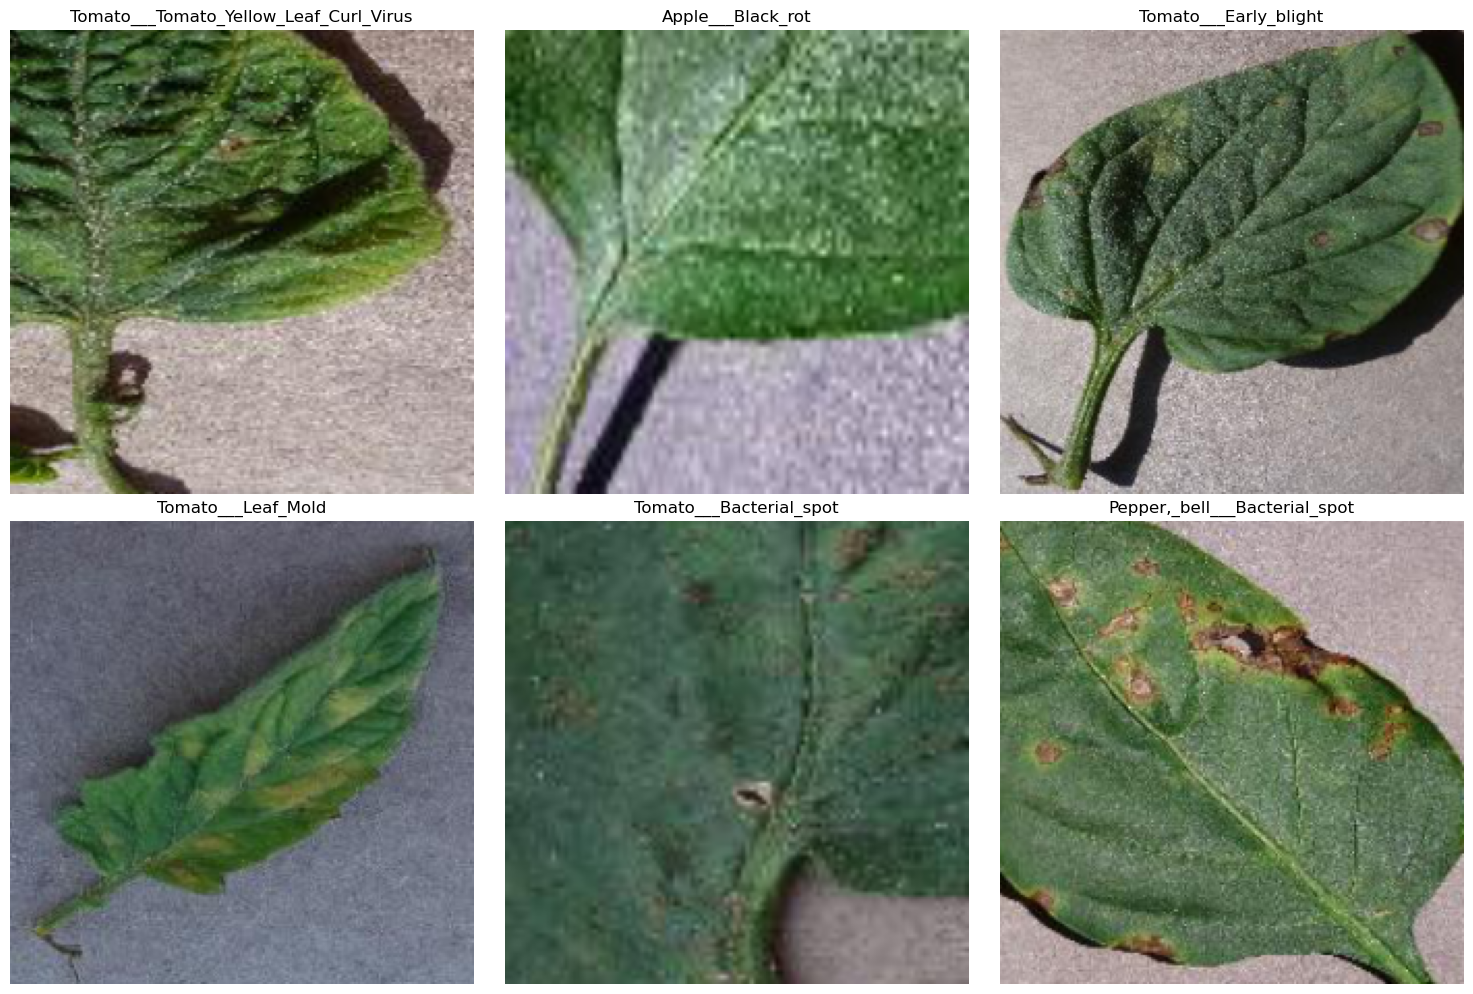

In [8]:
import matplotlib.pyplot as plt

# Reverse normalization function
def reverse_normalize(image, mean, std):
    """
    Reverse normalization of an image.
    Args:
        image (Tensor): Normalized image tensor (C, H, W).
        mean (tuple): Mean values for each channel.
        std (tuple): Standard deviations for each channel.
    Returns:
        image (ndarray): Denormalized image.
    """
    mean = np.array(mean)
    std = np.array(std)
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

class_indices = image_datasets.class_to_idx


# 增大图像显示区域的尺寸
plt.figure(figsize=(15, 10))

# Preview transformed images
for i in range(6):
    plt.subplot(2, 3, i+1)
    image, label = train_data[i]
    image = reverse_normalize(image, mean, std)
    plt.imshow(image)
    
    category_name = list(class_indices.keys())[label]  # 将整数标签转换为类别名
    plt.title(f'{category_name}')
    
    plt.axis('off')
    
plt.tight_layout()  # 调整子图间距，自动避免重叠
plt.show()

### 训练阶段

In [9]:
#hyperparameters
n_classes = 38
n_epochs = 15
batch_size = 16
learning_rate = 0.001

In [10]:
from torchinfo import summary
from torchvision.models import vision_transformer as vit
from torchvision.models.vision_transformer import ViT_B_16_Weights
import torch.nn as nn

# 根据实际有效的预训练权重
pretrained_weights = ViT_B_16_Weights.DEFAULT
model = vit.vit_b_16(weights=pretrained_weights, progress=True)
model.heads[0] = nn.Linear(model.heads[0].in_features, 38)  # 修改分类头为38类

# 检查模型是否成功加载并准备就绪
print(summary(model))


Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 768
├─Conv2d: 1-1                                                     590,592
├─Encoder: 1-2                                                    151,296
│    └─Dropout: 2-1                                               --
│    └─Sequential: 2-2                                            --
│    │    └─EncoderBlock: 3-1                                     7,087,872
│    │    └─EncoderBlock: 3-2                                     7,087,872
│    │    └─EncoderBlock: 3-3                                     7,087,872
│    │    └─EncoderBlock: 3-4                                     7,087,872
│    │    └─EncoderBlock: 3-5                                     7,087,872
│    │    └─EncoderBlock: 3-6                                     7,087,872
│    │    └─EncoderBlock: 3-7                                     7,087,872
│    │    └─EncoderBlock: 3-8         

In [11]:
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [12]:
from torch.utils.data import DataLoader

train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=True)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# 检查CUDA是否可用
if device.type == 'cuda':
    # 获取当前GPU设备属性
    device_properties = torch.cuda.get_device_properties(device.index)
    
    # 显存总量
    total_memory = device_properties.total_memory / (1024.0 ** 3)  # 单位转换为GB
    print(f"Total GPU memory: {total_memory:.2f} GB")

    # 已经分配的显存
    allocated_memory = torch.cuda.memory_allocated(device=device) / (1024.0 ** 3)
    print(f"Allocated GPU memory: {allocated_memory:.2f} GB")

    # 已经保留的显存（包括已分配和未分配但预留的部分）
    reserved_memory = torch.cuda.memory_reserved(device=device) / (1024.0 ** 3)
    print(f"Reserved GPU memory: {reserved_memory:.2f} GB")

else:
    print("CUDA is not available.")

Total GPU memory: 6.00 GB
Allocated GPU memory: 0.32 GB
Reserved GPU memory: 0.37 GB


Epoch 1:   0%|                                                                                | 0/1552 [00:00<?, ?it/s]E:\conda\envs\DTS101\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)

Epoch 1:   2%|█▏                                                          | 30/1552 [00:22<13:16,  1.91it/s, loss=3.63]


Epoch 1:   4%|██▍                                                         | 63/1552 [00:38<12:19,  2.01it/s, loss=3.56]


Epoch 1:   6%|███▋                                                        | 96/1552 [00:54<12:07,  2.00it/s, loss=3.36]


Epoch 1:   8%|████▉                                                      | 129/1552 [01:10<11:18,  2.10it/s, loss=3.56]


Epoch 1:  10%|██████▏                                                    | 162/1552 [01:26<11:11,  2.07it/s, loss=3.11]


Epoch 1:  13%|███████▍                                                   | 195/1552 [01:42<10:59,  2.06it/s, loss=3.12]


Epoch 1:  15%|████████▋                                                  | 228/1552 [01:58<10:51,  2.03it/s, loss=4.07]


Epoch 1:  17%|█████████▉                                                 | 261/1552 [02:14<10:26,  2.06it/s, loss=3.16]


Epoch 1:  19%|███████████▏                                               | 294/1552 [02:30<10:18,  2.04it/s, loss=2.51]


Epoch 1:  21%|████████████▍                                              | 327/1552 [02:46<10:05,  2.02it/s, loss=2.98]


Epoch 1:  23%|█████████████▋                                             | 360/1552 [03:03<09:43,  2.04it/s, loss=2.73]


Epoch 1:  25%|██████████████▉                                            | 393/1552 [03:19<09:28,  2.04it/s, loss=2.17]


Epoch 1:  27%|████████████████▏                                          | 426/1552 [03:35<09:16,  2.02it/s, loss=2.52]


Epoch 1:  30%|█████████████████▋                                          | 459/1552 [03:52<09:00,  2.02it/s, loss=2.5]


Epoch 1:  32%|██████████████████▋                                        | 492/1552 [04:08<08:45,  2.02it/s, loss=2.82]


Epoch 1:  34%|███████████████████▉                                       | 525/1552 [04:24<08:29,  2.01it/s, loss=1.77]


Epoch 1:  36%|█████████████████████▏                                     | 558/1552 [04:41<08:14,  2.01it/s, loss=2.12]


Epoch 1:  38%|██████████████████████▍                                    | 591/1552 [04:57<07:56,  2.02it/s, loss=1.91]


Epoch 1:  40%|███████████████████████▋                                   | 624/1552 [05:14<07:45,  1.99it/s, loss=1.61]


Epoch 1:  42%|████████████████████████▉                                  | 657/1552 [05:30<07:25,  2.01it/s, loss=1.34]


Epoch 1:  44%|██████████████████████████▏                                | 690/1552 [05:47<07:09,  2.01it/s, loss=1.97]


Epoch 1:  47%|███████████████████████████▍                               | 723/1552 [06:04<07:12,  1.92it/s, loss=1.11]


Epoch 1:  49%|████████████████████████████▋                              | 756/1552 [06:21<06:44,  1.97it/s, loss=1.54]


Epoch 1:  51%|█████████████████████████████▉                             | 789/1552 [06:37<06:19,  2.01it/s, loss=1.48]


Epoch 1:  53%|███████████████████████████████▏                           | 822/1552 [06:55<07:58,  1.53it/s, loss=1.45]


Epoch 1:  55%|████████████████████████████████▌                          | 855/1552 [07:13<05:59,  1.94it/s, loss=1.35]


Epoch 1:  57%|█████████████████████████████████▊                         | 888/1552 [07:30<05:38,  1.96it/s, loss=1.93]


Epoch 1:  59%|███████████████████████████████████▌                        | 921/1552 [07:47<05:16,  2.00it/s, loss=2.1]


Epoch 1:  61%|████████████████████████████████████▎                      | 954/1552 [08:03<05:02,  1.98it/s, loss=1.47]


Epoch 1:  64%|█████████████████████████████████████▌                     | 987/1552 [08:20<04:50,  1.94it/s, loss=1.82]


Epoch 1:  66%|██████████████████████████████████████▊                    | 1020/1552 [08:37<04:28,  1.98it/s, loss=1.8]


Epoch 1:  68%|███████████████████████████████████████▎                  | 1053/1552 [08:54<04:16,  1.95it/s, loss=1.86]


Epoch 1:  70%|████████████████████████████████████████▌                 | 1086/1552 [09:11<04:00,  1.94it/s, loss=0.79]


Epoch 1:  72%|██████████████████████████████████████████▌                | 1119/1552 [09:28<03:41,  1.96it/s, loss=1.9]


Epoch 1:  74%|███████████████████████████████████████████▊               | 1152/1552 [09:45<03:22,  1.97it/s, loss=1.3]


Epoch 1:  76%|████████████████████████████████████████████▎             | 1185/1552 [10:02<03:09,  1.94it/s, loss=1.39]


Epoch 1:  78%|█████████████████████████████████████████████▌            | 1218/1552 [10:19<02:51,  1.94it/s, loss=1.24]


Epoch 1:  81%|██████████████████████████████████████████████▊           | 1251/1552 [10:35<02:30,  2.00it/s, loss=1.24]


Epoch 1:  83%|███████████████████████████████████████████████▏         | 1284/1552 [10:52<02:16,  1.97it/s, loss=0.984]


Epoch 1:  85%|████████████████████████████████████████████████▎        | 1317/1552 [11:09<02:06,  1.86it/s, loss=0.851]


Epoch 1:  87%|██████████████████████████████████████████████████▍       | 1350/1552 [11:26<01:42,  1.97it/s, loss=1.34]


Epoch 1:  89%|██████████████████████████████████████████████████▊      | 1383/1552 [11:43<01:25,  1.97it/s, loss=0.689]


Epoch 1:  91%|████████████████████████████████████████████████████     | 1416/1552 [12:00<01:10,  1.92it/s, loss=0.923]


Epoch 1:  93%|██████████████████████████████████████████████████████▏   | 1449/1552 [12:17<00:53,  1.92it/s, loss=1.11]


Epoch 1:  95%|██████████████████████████████████████████████████████▍  | 1482/1552 [12:34<00:35,  1.96it/s, loss=0.648]


Epoch 1:  98%|█████████████████████████████████████████████████████████▌ | 1515/1552 [12:51<00:18,  1.97it/s, loss=1.4]


Epoch 1: 100%|████████████████████████████████████████████████████████▊| 1548/1552 [13:08<00:02,  1.89it/s, loss=0.709]


Epoch 2:   2%|█                                                          | 28/1552 [00:15<13:29,  1.88it/s, loss=0.425]


Epoch 2:   4%|██▎                                                        | 61/1552 [00:33<13:21,  1.86it/s, loss=0.807]


Epoch 2:   6%|███▋                                                        | 94/1552 [00:50<13:05,  1.86it/s, loss=1.01]


Epoch 2:   8%|████▊                                                      | 127/1552 [01:08<12:48,  1.86it/s, loss=2.34]


Epoch 2:  10%|██████                                                     | 160/1552 [01:25<12:10,  1.91it/s, loss=1.19]


Epoch 2:  12%|███████▎                                                   | 193/1552 [01:43<12:05,  1.87it/s, loss=1.29]


Epoch 2:  15%|████████▌                                                  | 226/1552 [02:01<11:38,  1.90it/s, loss=1.25]


Epoch 2:  17%|█████████▊                                                 | 259/1552 [02:19<11:36,  1.86it/s, loss=1.72]


Epoch 2:  19%|███████████                                                | 292/1552 [02:36<11:13,  1.87it/s, loss=1.36]


Epoch 2:  21%|████████████▏                                             | 325/1552 [02:54<10:52,  1.88it/s, loss=0.868]


Epoch 2:  23%|█████████████▍                                            | 358/1552 [03:12<10:32,  1.89it/s, loss=0.953]


Epoch 2:  25%|███████████████                                             | 391/1552 [03:29<10:23,  1.86it/s, loss=1.2]


Epoch 2:  27%|████████████████                                           | 424/1552 [03:47<10:06,  1.86it/s, loss=1.03]


Epoch 2:  29%|█████████████████                                         | 457/1552 [04:04<09:46,  1.87it/s, loss=0.782]


Epoch 2:  32%|██████████████████▎                                       | 490/1552 [04:22<09:27,  1.87it/s, loss=0.612]


Epoch 2:  34%|███████████████████▌                                      | 523/1552 [04:40<09:06,  1.88it/s, loss=0.457]


Epoch 2:  36%|████████████████████▊                                     | 556/1552 [04:58<08:49,  1.88it/s, loss=0.682]


Epoch 2:  38%|██████████████████████▊                                     | 589/1552 [05:15<08:49,  1.82it/s, loss=0.9]


Epoch 2:  40%|███████████████████████▏                                  | 622/1552 [05:33<08:25,  1.84it/s, loss=0.307]


Epoch 2:  42%|████████████████████████▉                                  | 655/1552 [05:51<08:03,  1.85it/s, loss=1.03]


Epoch 2:  44%|█████████████████████████▋                                | 688/1552 [06:08<07:48,  1.84it/s, loss=0.906]


Epoch 2:  46%|██████████████████████████▉                               | 721/1552 [06:26<07:18,  1.90it/s, loss=0.896]


Epoch 2:  49%|█████████████████████████████▏                              | 754/1552 [06:44<07:15,  1.83it/s, loss=1.4]


Epoch 2:  51%|█████████████████████████████▉                             | 787/1552 [07:02<06:45,  1.89it/s, loss=0.68]


Epoch 2:  53%|██████████████████████████████▋                           | 820/1552 [07:20<06:31,  1.87it/s, loss=0.412]


Epoch 2:  55%|███████████████████████████████▉                          | 853/1552 [07:37<06:10,  1.89it/s, loss=0.527]


Epoch 2:  57%|█████████████████████████████████                         | 886/1552 [07:55<05:55,  1.87it/s, loss=0.713]


Epoch 2:  59%|██████████████████████████████████▉                        | 919/1552 [08:13<05:42,  1.85it/s, loss=1.13]


Epoch 2:  61%|███████████████████████████████████▌                      | 952/1552 [08:31<05:20,  1.87it/s, loss=0.835]


Epoch 2:  63%|████████████████████████████████████▊                     | 985/1552 [08:49<05:12,  1.81it/s, loss=0.597]


Epoch 2:  66%|█████████████████████████████████████▍                   | 1018/1552 [09:07<04:41,  1.90it/s, loss=0.773]


Epoch 2:  68%|██████████████████████████████████████▌                  | 1051/1552 [09:24<04:22,  1.91it/s, loss=0.881]


Epoch 2:  70%|████████████████████████████████████████▌                 | 1084/1552 [09:42<04:09,  1.88it/s, loss=2.09]


Epoch 2:  72%|█████████████████████████████████████████                | 1117/1552 [10:00<03:53,  1.86it/s, loss=0.498]


Epoch 2:  74%|██████████████████████████████████████████▉               | 1150/1552 [10:18<03:37,  1.85it/s, loss=1.59]


Epoch 2:  76%|████████████████████████████████████████████▏             | 1183/1552 [10:36<03:21,  1.83it/s, loss=1.07]


Epoch 2:  78%|████████████████████████████████████████████▋            | 1216/1552 [10:54<03:03,  1.83it/s, loss=0.624]


Epoch 2:  80%|█████████████████████████████████████████████▊           | 1249/1552 [11:12<02:51,  1.76it/s, loss=0.909]


Epoch 2:  83%|███████████████████████████████████████████████          | 1282/1552 [11:30<02:27,  1.83it/s, loss=0.773]


Epoch 2:  85%|████████████████████████████████████████████████▎        | 1315/1552 [11:48<02:06,  1.88it/s, loss=0.592]


Epoch 2:  87%|█████████████████████████████████████████████████▌       | 1348/1552 [12:06<01:50,  1.84it/s, loss=0.494]


Epoch 2:  89%|███████████████████████████████████████████████████▌      | 1381/1552 [12:24<01:30,  1.88it/s, loss=1.13]


Epoch 2:  91%|███████████████████████████████████████████████████▉     | 1414/1552 [12:42<01:13,  1.87it/s, loss=0.987]


Epoch 2:  93%|█████████████████████████████████████████████████████▏   | 1447/1552 [12:59<00:57,  1.83it/s, loss=0.817]


Epoch 2:  95%|██████████████████████████████████████████████████████▎  | 1480/1552 [13:17<00:38,  1.87it/s, loss=0.756]


Epoch 2:  97%|███████████████████████████████████████████████████████▌ | 1513/1552 [13:35<00:20,  1.87it/s, loss=0.265]


Epoch 2: 100%|████████████████████████████████████████████████████████▊| 1546/1552 [13:53<00:03,  1.87it/s, loss=0.671]


Epoch 3:   2%|█                                                           | 26/1552 [00:14<13:36,  1.87it/s, loss=0.89]


Epoch 3:   4%|██▎                                                         | 59/1552 [00:31<13:19,  1.87it/s, loss=1.05]


Epoch 3:   6%|███▌                                                        | 92/1552 [00:50<13:34,  1.79it/s, loss=1.61]


Epoch 3:   8%|████▊                                                      | 125/1552 [01:07<13:05,  1.82it/s, loss=0.67]


Epoch 3:  10%|█████▉                                                    | 158/1552 [01:26<13:49,  1.68it/s, loss=0.485]


Epoch 3:  12%|███████▏                                                  | 191/1552 [01:44<12:58,  1.75it/s, loss=0.583]


Epoch 3:  14%|████████▎                                                 | 224/1552 [02:02<11:54,  1.86it/s, loss=0.543]


Epoch 3:  17%|█████████▌                                                | 257/1552 [02:20<11:30,  1.88it/s, loss=0.332]


Epoch 3:  19%|██████████▊                                               | 290/1552 [02:39<11:40,  1.80it/s, loss=0.798]


Epoch 3:  21%|████████████                                              | 323/1552 [02:57<11:38,  1.76it/s, loss=0.358]


Epoch 3:  23%|█████████████▎                                            | 356/1552 [03:15<11:06,  1.79it/s, loss=0.427]


Epoch 3:  25%|██████████████▌                                           | 389/1552 [03:33<10:40,  1.82it/s, loss=0.744]


Epoch 3:  27%|████████████████▎                                           | 422/1552 [03:51<10:12,  1.85it/s, loss=1.5]


Epoch 3:  29%|█████████████████▎                                         | 455/1552 [04:09<10:06,  1.81it/s, loss=1.33]


Epoch 3:  31%|██████████████████▏                                       | 488/1552 [04:27<09:27,  1.87it/s, loss=0.345]


Epoch 3:  34%|███████████████████▍                                      | 521/1552 [04:45<09:17,  1.85it/s, loss=0.404]


Epoch 3:  36%|████████████████████▋                                     | 554/1552 [05:03<09:20,  1.78it/s, loss=0.254]


Epoch 3:  38%|█████████████████████▉                                    | 587/1552 [05:22<09:10,  1.75it/s, loss=0.508]


Epoch 3:  40%|███████████████████████▉                                    | 620/1552 [05:40<08:26,  1.84it/s, loss=0.6]


Epoch 3:  42%|████████████████████████▍                                 | 653/1552 [05:58<07:58,  1.88it/s, loss=0.234]


Epoch 3:  44%|█████████████████████████▋                                | 686/1552 [06:16<08:00,  1.80it/s, loss=0.717]


Epoch 3:  46%|██████████████████████████▊                               | 719/1552 [06:35<07:40,  1.81it/s, loss=0.617]


Epoch 3:  48%|████████████████████████████                              | 752/1552 [06:53<07:08,  1.87it/s, loss=0.963]


Epoch 3:  51%|█████████████████████████████▎                            | 785/1552 [07:11<07:02,  1.81it/s, loss=0.585]


Epoch 3:  53%|██████████████████████████████▌                           | 818/1552 [07:29<06:47,  1.80it/s, loss=0.219]


Epoch 3:  55%|███████████████████████████████▊                          | 851/1552 [07:48<06:22,  1.83it/s, loss=0.679]


Epoch 3:  57%|█████████████████████████████████                         | 884/1552 [08:06<05:56,  1.87it/s, loss=0.423]


Epoch 3:  59%|███████████████████████████████████▍                        | 917/1552 [08:24<06:00,  1.76it/s, loss=1.2]


Epoch 3:  61%|███████████████████████████████████▌                      | 950/1552 [08:43<05:52,  1.71it/s, loss=0.552]


Epoch 3:  63%|████████████████████████████████████▋                     | 983/1552 [09:01<05:08,  1.84it/s, loss=0.321]


Epoch 3:  65%|█████████████████████████████████████▉                    | 1016/1552 [09:19<04:46,  1.87it/s, loss=1.03]


Epoch 3:  68%|██████████████████████████████████████▌                  | 1049/1552 [09:37<04:42,  1.78it/s, loss=0.929]


Epoch 3:  70%|███████████████████████████████████████▋                 | 1082/1552 [09:55<04:14,  1.85it/s, loss=0.221]


Epoch 3:  72%|████████████████████████████████████████▉                | 1115/1552 [10:13<03:56,  1.85it/s, loss=0.336]


Epoch 3:  74%|██████████████████████████████████████████▏              | 1148/1552 [10:31<03:38,  1.85it/s, loss=0.327]


Epoch 3:  76%|███████████████████████████████████████████▎             | 1181/1552 [10:50<03:30,  1.76it/s, loss=0.136]


Epoch 3:  78%|████████████████████████████████████████████▌            | 1214/1552 [11:08<03:06,  1.81it/s, loss=0.767]


Epoch 3:  80%|█████████████████████████████████████████████▊           | 1247/1552 [11:27<02:55,  1.73it/s, loss=0.725]


Epoch 3:  82%|███████████████████████████████████████████████          | 1280/1552 [11:45<02:27,  1.85it/s, loss=0.395]


Epoch 3:  85%|████████████████████████████████████████████████▏        | 1313/1552 [12:03<02:10,  1.83it/s, loss=0.414]


Epoch 3:  87%|█████████████████████████████████████████████████▍       | 1346/1552 [12:22<01:57,  1.76it/s, loss=0.679]


Epoch 3:  89%|██████████████████████████████████████████████████▋      | 1379/1552 [12:41<01:41,  1.71it/s, loss=0.653]


Epoch 3:  91%|███████████████████████████████████████████████████▊     | 1412/1552 [12:59<01:16,  1.84it/s, loss=0.432]


Epoch 3:  93%|█████████████████████████████████████████████████████    | 1445/1552 [13:18<00:58,  1.83it/s, loss=0.311]


Epoch 3:  95%|██████████████████████████████████████████████████████▎  | 1478/1552 [13:36<00:41,  1.77it/s, loss=0.857]


Epoch 3:  97%|███████████████████████████████████████████████████████▍ | 1511/1552 [13:54<00:21,  1.87it/s, loss=0.951]


Epoch 3:  99%|████████████████████████████████████████████████████████▋| 1544/1552 [14:13<00:04,  1.85it/s, loss=0.915]


Epoch 4:   2%|▉                                                          | 24/1552 [00:13<14:11,  1.79it/s, loss=0.443]


Epoch 4:   4%|██▏                                                        | 57/1552 [00:31<13:48,  1.81it/s, loss=0.688]


Epoch 4:   6%|███▍                                                       | 90/1552 [00:50<13:52,  1.76it/s, loss=0.355]


Epoch 4:   8%|████▌                                                     | 123/1552 [01:08<13:48,  1.73it/s, loss=0.644]


Epoch 4:  10%|█████▊                                                    | 156/1552 [01:27<13:13,  1.76it/s, loss=0.539]


Epoch 4:  12%|███████                                                   | 189/1552 [01:45<12:15,  1.85it/s, loss=0.412]


Epoch 4:  14%|████████▎                                                 | 222/1552 [02:03<12:17,  1.80it/s, loss=0.514]


Epoch 4:  16%|█████████▋                                                 | 255/1552 [02:21<11:55,  1.81it/s, loss=0.43]


Epoch 4:  19%|██████████▉                                                | 288/1552 [02:39<11:11,  1.88it/s, loss=0.66]


Epoch 4:  21%|████████████▏                                              | 321/1552 [02:58<11:08,  1.84it/s, loss=1.13]


Epoch 4:  23%|█████████████▏                                            | 354/1552 [03:16<11:21,  1.76it/s, loss=0.365]


Epoch 4:  25%|██████████████▍                                           | 387/1552 [03:34<11:04,  1.75it/s, loss=0.385]


Epoch 4:  27%|███████████████▋                                          | 420/1552 [03:53<10:21,  1.82it/s, loss=0.516]


Epoch 4:  29%|████████████████▉                                         | 453/1552 [04:11<10:26,  1.75it/s, loss=0.829]


Epoch 4:  31%|██████████████████▏                                       | 486/1552 [04:29<09:32,  1.86it/s, loss=0.631]


Epoch 4:  33%|███████████████████▍                                      | 519/1552 [04:47<09:25,  1.83it/s, loss=0.532]


Epoch 4:  36%|████████████████████▋                                     | 552/1552 [05:06<09:29,  1.76it/s, loss=0.481]


Epoch 4:  38%|█████████████████████▊                                    | 585/1552 [05:24<09:13,  1.75it/s, loss=0.354]


Epoch 4:  40%|███████████████████████                                   | 618/1552 [05:42<08:30,  1.83it/s, loss=0.267]


Epoch 4:  42%|████████████████████████▎                                 | 651/1552 [06:01<08:21,  1.80it/s, loss=0.174]


Epoch 4:  44%|█████████████████████████▌                                | 684/1552 [06:19<07:57,  1.82it/s, loss=0.419]


Epoch 4:  46%|███████████████████████████▎                               | 717/1552 [06:37<07:33,  1.84it/s, loss=0.59]


Epoch 4:  48%|████████████████████████████                              | 750/1552 [06:55<07:38,  1.75it/s, loss=0.404]


Epoch 4:  50%|█████████████████████████████▎                            | 783/1552 [07:13<07:00,  1.83it/s, loss=0.664]


Epoch 4:  53%|██████████████████████████████▍                           | 816/1552 [07:32<06:50,  1.79it/s, loss=0.798]


Epoch 4:  55%|███████████████████████████████▋                          | 849/1552 [07:51<06:47,  1.73it/s, loss=0.711]


Epoch 4:  57%|████████████████████████████████▉                         | 882/1552 [08:09<06:22,  1.75it/s, loss=0.517]


Epoch 4:  59%|██████████████████████████████████▏                       | 915/1552 [08:27<05:42,  1.86it/s, loss=0.303]


Epoch 4:  61%|███████████████████████████████████▍                      | 948/1552 [08:46<05:35,  1.80it/s, loss=0.201]


Epoch 4:  63%|█████████████████████████████████████▉                      | 981/1552 [09:04<05:23,  1.77it/s, loss=1.2]


Epoch 4:  65%|████████████████████████████████████▌                   | 1014/1552 [09:22<04:50,  1.85it/s, loss=0.0834]


Epoch 4:  67%|██████████████████████████████████████▍                  | 1047/1552 [09:41<04:27,  1.89it/s, loss=0.383]


Epoch 4:  70%|████████████████████████████████████████▎                 | 1080/1552 [09:59<04:27,  1.77it/s, loss=0.18]


Epoch 4:  72%|████████████████████████████████████████▉                | 1113/1552 [10:17<04:02,  1.81it/s, loss=0.683]


Epoch 4:  74%|██████████████████████████████████████████               | 1146/1552 [10:36<03:43,  1.81it/s, loss=0.595]


Epoch 4:  76%|███████████████████████████████████████████▎             | 1179/1552 [10:54<03:27,  1.80it/s, loss=0.177]


Epoch 4:  78%|████████████████████████████████████████████▌            | 1212/1552 [11:13<03:08,  1.81it/s, loss=0.464]


Epoch 4:  80%|█████████████████████████████████████████████▋           | 1245/1552 [11:31<02:48,  1.82it/s, loss=0.414]


Epoch 4:  82%|███████████████████████████████████████████████▊          | 1278/1552 [11:50<02:32,  1.79it/s, loss=0.91]


Epoch 4:  84%|████████████████████████████████████████████████▏        | 1311/1552 [12:08<02:11,  1.83it/s, loss=0.926]


Epoch 4:  87%|██████████████████████████████████████████████████▏       | 1344/1552 [12:26<01:52,  1.84it/s, loss=0.76]


Epoch 4:  89%|██████████████████████████████████████████████████▌      | 1377/1552 [12:44<01:34,  1.85it/s, loss=0.452]


Epoch 4:  91%|███████████████████████████████████████████████████▊     | 1410/1552 [13:03<01:19,  1.79it/s, loss=0.302]


Epoch 4:  93%|█████████████████████████████████████████████████████▉    | 1443/1552 [13:22<01:03,  1.70it/s, loss=0.37]


Epoch 4:  95%|██████████████████████████████████████████████████████▏  | 1476/1552 [13:40<00:42,  1.77it/s, loss=0.691]


Epoch 4:  97%|███████████████████████████████████████████████████████▍ | 1509/1552 [13:58<00:23,  1.83it/s, loss=0.926]


Epoch 4:  99%|████████████████████████████████████████████████████████▋| 1542/1552 [14:16<00:05,  1.78it/s, loss=0.668]


Epoch 5:   1%|▊                                                          | 22/1552 [00:12<13:53,  1.83it/s, loss=0.816]


Epoch 5:   4%|██▏                                                         | 55/1552 [00:31<14:05,  1.77it/s, loss=0.27]


Epoch 5:   6%|███▎                                                       | 88/1552 [00:49<13:18,  1.83it/s, loss=0.696]


Epoch 5:   8%|████▌                                                      | 121/1552 [01:08<13:21,  1.79it/s, loss=0.17]


Epoch 5:  10%|█████▊                                                    | 154/1552 [01:26<13:29,  1.73it/s, loss=0.654]


Epoch 5:  12%|██████▉                                                   | 187/1552 [01:45<13:18,  1.71it/s, loss=0.201]


Epoch 5:  14%|████████▏                                                 | 220/1552 [02:05<13:22,  1.66it/s, loss=0.219]


Epoch 5:  16%|█████████▍                                                | 253/1552 [02:23<12:04,  1.79it/s, loss=0.562]


Epoch 5:  18%|██████████▋                                               | 286/1552 [02:42<11:59,  1.76it/s, loss=0.691]


Epoch 5:  21%|███████████▉                                              | 319/1552 [03:00<11:10,  1.84it/s, loss=0.265]


Epoch 5:  23%|█████████████▏                                            | 352/1552 [03:19<11:14,  1.78it/s, loss=0.416]


Epoch 5:  25%|██████████████▋                                            | 385/1552 [03:37<10:59,  1.77it/s, loss=0.24]


Epoch 5:  27%|███████████████▌                                          | 418/1552 [03:56<10:48,  1.75it/s, loss=0.369]


Epoch 5:  29%|████████████████▊                                         | 451/1552 [04:14<10:09,  1.81it/s, loss=0.345]


Epoch 5:  31%|██████████████████                                        | 484/1552 [04:33<10:28,  1.70it/s, loss=0.216]


Epoch 5:  33%|███████████████████▋                                       | 517/1552 [04:51<09:23,  1.84it/s, loss=0.41]


Epoch 5:  35%|████████████████████▌                                     | 550/1552 [05:10<09:55,  1.68it/s, loss=0.618]


Epoch 5:  38%|█████████████████████▊                                    | 583/1552 [05:28<09:01,  1.79it/s, loss=0.462]


Epoch 5:  40%|███████████████████████                                   | 616/1552 [05:47<08:39,  1.80it/s, loss=0.215]


Epoch 5:  42%|████████████████████████▎                                 | 649/1552 [06:05<08:30,  1.77it/s, loss=0.577]


Epoch 5:  44%|█████████████████████████▍                                | 682/1552 [06:24<08:30,  1.70it/s, loss=0.832]


Epoch 5:  46%|███████████████████████████▏                               | 715/1552 [06:42<07:50,  1.78it/s, loss=1.14]


Epoch 5:  48%|███████████████████████████▉                              | 748/1552 [07:00<07:25,  1.80it/s, loss=0.154]


Epoch 5:  50%|█████████████████████████████▏                            | 781/1552 [07:19<06:53,  1.86it/s, loss=0.952]


Epoch 5:  52%|██████████████████████████████▍                           | 814/1552 [07:37<06:58,  1.77it/s, loss=0.358]


Epoch 5:  55%|███████████████████████████████▋                          | 847/1552 [07:56<06:53,  1.70it/s, loss=0.315]


Epoch 5:  57%|████████████████████████████████▉                         | 880/1552 [08:14<06:25,  1.74it/s, loss=0.435]


Epoch 5:  59%|██████████████████████████████████                        | 913/1552 [08:33<06:03,  1.76it/s, loss=0.413]


Epoch 5:  61%|███████████████████████████████████▎                      | 946/1552 [08:51<05:46,  1.75it/s, loss=0.733]


Epoch 5:  63%|█████████████████████████████████████▏                     | 979/1552 [09:09<05:13,  1.83it/s, loss=0.58]


Epoch 5:  65%|█████████████████████████████████████▏                   | 1012/1552 [09:28<05:08,  1.75it/s, loss=0.541]


Epoch 5:  67%|██████████████████████████████████████▍                  | 1045/1552 [09:46<04:33,  1.86it/s, loss=0.642]


Epoch 5:  69%|███████████████████████████████████████▌                 | 1078/1552 [10:05<04:36,  1.71it/s, loss=0.648]


Epoch 5:  72%|████████████████████████████████████████▊                | 1111/1552 [10:24<04:19,  1.70it/s, loss=0.738]


Epoch 5:  74%|██████████████████████████████████████████               | 1144/1552 [10:42<03:52,  1.76it/s, loss=0.242]


Epoch 5:  76%|███████████████████████████████████████████▏             | 1177/1552 [11:00<03:21,  1.86it/s, loss=0.319]


Epoch 5:  78%|████████████████████████████████████████████▍            | 1210/1552 [11:19<03:13,  1.77it/s, loss=0.424]


Epoch 5:  80%|█████████████████████████████████████████████▋           | 1243/1552 [11:37<02:54,  1.77it/s, loss=0.527]


Epoch 5:  82%|██████████████████████████████████████████████▊          | 1276/1552 [11:55<02:32,  1.82it/s, loss=0.394]


Epoch 5:  84%|████████████████████████████████████████████████         | 1309/1552 [12:14<02:17,  1.76it/s, loss=0.331]


Epoch 5:  86%|█████████████████████████████████████████████████▎       | 1342/1552 [12:33<01:58,  1.77it/s, loss=0.538]


Epoch 5:  89%|███████████████████████████████████████████████████▍      | 1375/1552 [12:51<01:37,  1.82it/s, loss=0.29]


Epoch 5:  91%|███████████████████████████████████████████████████▋     | 1408/1552 [13:10<01:18,  1.83it/s, loss=0.357]


Epoch 5:  93%|████████████████████████████████████████████████████▉    | 1441/1552 [13:28<01:03,  1.76it/s, loss=0.545]


Epoch 5:  95%|██████████████████████████████████████████████████████▏  | 1474/1552 [13:47<00:44,  1.74it/s, loss=0.785]


Epoch 5:  97%|███████████████████████████████████████████████████████▎ | 1507/1552 [14:05<00:24,  1.82it/s, loss=0.202]


Epoch 5:  99%|█████████████████████████████████████████████████████████▌| 1540/1552 [14:24<00:06,  1.79it/s, loss=0.32]


Epoch 6:   1%|▊                                                          | 20/1552 [00:11<14:01,  1.82it/s, loss=0.992]


Epoch 6:   3%|██                                                         | 53/1552 [00:29<13:43,  1.82it/s, loss=0.306]


Epoch 6:   6%|███▎                                                       | 86/1552 [00:48<13:11,  1.85it/s, loss=0.313]


Epoch 6:   8%|████▍                                                     | 119/1552 [01:06<13:00,  1.84it/s, loss=0.435]


Epoch 6:  10%|█████▋                                                    | 152/1552 [01:25<13:34,  1.72it/s, loss=0.476]


Epoch 6:  12%|██████▉                                                   | 185/1552 [01:43<13:23,  1.70it/s, loss=0.397]


Epoch 6:  14%|████████▏                                                 | 218/1552 [02:02<12:03,  1.84it/s, loss=0.515]


Epoch 6:  16%|█████████▍                                                | 251/1552 [02:20<11:41,  1.85it/s, loss=0.599]


Epoch 6:  18%|██████████▌                                               | 284/1552 [02:39<11:27,  1.84it/s, loss=0.238]


Epoch 6:  20%|███████████▊                                              | 317/1552 [02:57<11:52,  1.73it/s, loss=0.711]


Epoch 6:  23%|█████████████                                             | 350/1552 [03:15<10:58,  1.83it/s, loss=0.361]


Epoch 6:  25%|██████████████▎                                           | 383/1552 [03:34<11:03,  1.76it/s, loss=0.863]


Epoch 6:  27%|███████████████▌                                          | 416/1552 [03:53<10:32,  1.80it/s, loss=0.429]


Epoch 6:  29%|████████████████▊                                         | 449/1552 [04:11<10:10,  1.81it/s, loss=0.418]


Epoch 6:  31%|██████████████████                                        | 482/1552 [04:30<10:02,  1.78it/s, loss=0.281]


Epoch 6:  33%|███████████████████▌                                       | 515/1552 [04:48<10:00,  1.73it/s, loss=1.01]


Epoch 6:  35%|████████████████████▍                                     | 548/1552 [05:07<09:11,  1.82it/s, loss=0.207]


Epoch 6:  37%|█████████████████████▋                                    | 581/1552 [05:25<08:59,  1.80it/s, loss=0.453]


Epoch 6:  40%|██████████████████████▉                                   | 614/1552 [05:44<08:53,  1.76it/s, loss=0.336]


Epoch 6:  42%|████████████████████████▏                                 | 647/1552 [06:02<08:28,  1.78it/s, loss=0.117]


Epoch 6:  44%|█████████████████████████▍                                | 680/1552 [06:21<07:47,  1.87it/s, loss=0.188]


Epoch 6:  46%|██████████████████████████▋                               | 713/1552 [06:39<07:36,  1.84it/s, loss=0.301]


Epoch 6:  48%|███████████████████████████▉                              | 746/1552 [06:58<07:24,  1.81it/s, loss=0.578]


Epoch 6:  50%|█████████████████████████████                             | 779/1552 [07:16<07:02,  1.83it/s, loss=0.416]


Epoch 6:  52%|██████████████████████████████▎                           | 812/1552 [07:35<06:54,  1.78it/s, loss=0.538]


Epoch 6:  54%|████████████████████████████████                           | 845/1552 [07:53<06:33,  1.80it/s, loss=0.74]


Epoch 6:  57%|█████████████████████████████████▍                         | 878/1552 [08:12<06:05,  1.84it/s, loss=0.34]


Epoch 6:  59%|██████████████████████████████████                        | 911/1552 [08:30<05:57,  1.79it/s, loss=0.492]


Epoch 6:  61%|███████████████████████████████████▎                      | 944/1552 [08:49<05:46,  1.76it/s, loss=0.759]


Epoch 6:  63%|████████████████████████████████████▌                     | 977/1552 [09:07<05:24,  1.77it/s, loss=0.831]


Epoch 6:  65%|█████████████████████████████████████                    | 1010/1552 [09:25<05:06,  1.77it/s, loss=0.571]


Epoch 6:  67%|██████████████████████████████████████▎                  | 1043/1552 [09:44<04:57,  1.71it/s, loss=0.471]


Epoch 6:  69%|███████████████████████████████████████▌                 | 1076/1552 [10:02<04:26,  1.79it/s, loss=0.583]


Epoch 6:  71%|████████████████████████████████████████▋                | 1109/1552 [10:21<04:15,  1.73it/s, loss=0.484]


Epoch 6:  74%|█████████████████████████████████████████▉               | 1142/1552 [10:40<03:49,  1.78it/s, loss=0.251]


Epoch 6:  76%|██████████████████████████████████████████▍             | 1175/1552 [10:58<03:29,  1.80it/s, loss=0.0812]


Epoch 6:  78%|████████████████████████████████████████████▎            | 1208/1552 [11:17<03:12,  1.79it/s, loss=0.579]


Epoch 6:  80%|█████████████████████████████████████████████▌           | 1241/1552 [11:35<02:55,  1.77it/s, loss=0.424]


Epoch 6:  82%|██████████████████████████████████████████████▊          | 1274/1552 [11:54<02:40,  1.74it/s, loss=0.271]


Epoch 6:  84%|████████████████████████████████████████████████         | 1307/1552 [12:12<02:18,  1.76it/s, loss=0.602]


Epoch 6:  86%|█████████████████████████████████████████████████▏       | 1340/1552 [12:31<01:55,  1.84it/s, loss=0.162]


Epoch 6:  88%|██████████████████████████████████████████████████▍      | 1373/1552 [12:49<01:39,  1.80it/s, loss=0.153]


Epoch 6:  91%|████████████████████████████████████████████████████▌     | 1406/1552 [13:08<01:24,  1.73it/s, loss=1.22]


Epoch 6:  93%|████████████████████████████████████████████████████▊    | 1439/1552 [13:26<01:02,  1.81it/s, loss=0.289]


Epoch 6:  95%|███████████████████████████████████████████████████████   | 1472/1552 [13:45<00:46,  1.71it/s, loss=0.17]


Epoch 6:  97%|███████████████████████████████████████████████████████▎ | 1505/1552 [14:03<00:26,  1.79it/s, loss=0.492]


Epoch 6:  99%|████████████████████████████████████████████████████████▍| 1538/1552 [14:21<00:07,  1.78it/s, loss=0.451]


Epoch 7:   1%|▋                                                          | 18/1552 [00:10<14:40,  1.74it/s, loss=0.554]


Epoch 7:   3%|█▉                                                         | 51/1552 [00:29<13:44,  1.82it/s, loss=0.236]


Epoch 7:   5%|███▏                                                       | 84/1552 [00:47<13:36,  1.80it/s, loss=0.315]


Epoch 7:   8%|████▎                                                     | 117/1552 [01:06<13:33,  1.76it/s, loss=0.404]


Epoch 7:  10%|█████▌                                                    | 150/1552 [01:24<12:53,  1.81it/s, loss=0.421]


Epoch 7:  12%|██████▊                                                   | 183/1552 [01:42<12:17,  1.86it/s, loss=0.638]


Epoch 7:  14%|████████                                                  | 216/1552 [02:01<12:10,  1.83it/s, loss=0.146]


Epoch 7:  16%|█████████▎                                                | 249/1552 [02:19<12:09,  1.79it/s, loss=0.709]


Epoch 7:  18%|██████████▋                                                | 282/1552 [02:38<13:19,  1.59it/s, loss=0.62]


Epoch 7:  20%|███████████▊                                              | 315/1552 [02:56<12:00,  1.72it/s, loss=0.398]


Epoch 7:  22%|█████████████                                             | 348/1552 [03:15<11:13,  1.79it/s, loss=0.564]


Epoch 7:  25%|██████████████▏                                           | 381/1552 [03:33<11:16,  1.73it/s, loss=0.521]


Epoch 7:  27%|███████████████▍                                          | 414/1552 [03:52<10:56,  1.73it/s, loss=0.192]


Epoch 7:  29%|████████████████▋                                         | 447/1552 [04:10<10:07,  1.82it/s, loss=0.091]


Epoch 7:  31%|█████████████████▉                                        | 480/1552 [04:29<10:29,  1.70it/s, loss=0.419]


Epoch 7:  33%|███████████████████▏                                      | 513/1552 [04:48<09:45,  1.78it/s, loss=0.553]


Epoch 7:  35%|████████████████████                                     | 546/1552 [05:06<09:27,  1.77it/s, loss=0.0881]


Epoch 7:  37%|█████████████████████▋                                    | 579/1552 [05:25<09:21,  1.73it/s, loss=0.577]


Epoch 7:  39%|██████████████████████▊                                   | 612/1552 [05:43<08:28,  1.85it/s, loss=0.507]


Epoch 7:  42%|████████████████████████                                  | 645/1552 [06:02<08:43,  1.73it/s, loss=0.646]


Epoch 7:  44%|█████████████████████████▎                                | 678/1552 [06:20<08:01,  1.82it/s, loss=0.436]


Epoch 7:  46%|██████████████████████████▌                               | 711/1552 [06:39<07:37,  1.84it/s, loss=0.249]


Epoch 7:  48%|███████████████████████████▊                              | 744/1552 [06:57<07:27,  1.80it/s, loss=0.317]


Epoch 7:  50%|█████████████████████████████                             | 777/1552 [07:16<07:00,  1.84it/s, loss=0.825]


Epoch 7:  52%|██████████████████████████████▎                           | 810/1552 [07:34<06:49,  1.81it/s, loss=0.357]


Epoch 7:  54%|███████████████████████████████▌                          | 843/1552 [07:53<06:43,  1.76it/s, loss=0.303]


Epoch 7:  56%|████████████████████████████████▋                         | 876/1552 [08:11<05:59,  1.88it/s, loss=0.678]


Epoch 7:  59%|█████████████████████████████████▍                       | 909/1552 [08:29<06:03,  1.77it/s, loss=0.0902]


Epoch 7:  61%|██████████████████████████████████▌                      | 942/1552 [08:48<05:46,  1.76it/s, loss=0.0277]


Epoch 7:  63%|████████████████████████████████████▍                     | 975/1552 [09:06<05:24,  1.78it/s, loss=0.549]


Epoch 7:  65%|█████████████████████████████████████                    | 1008/1552 [09:25<04:58,  1.82it/s, loss=0.167]


Epoch 7:  67%|██████████████████████████████████████▏                  | 1041/1552 [09:43<04:40,  1.82it/s, loss=0.231]


Epoch 7:  69%|███████████████████████████████████████▍                 | 1074/1552 [10:02<04:32,  1.75it/s, loss=0.306]


Epoch 7:  71%|████████████████████████████████████████▋                | 1107/1552 [10:21<04:12,  1.76it/s, loss=0.159]


Epoch 7:  73%|█████████████████████████████████████████▊               | 1140/1552 [10:39<03:52,  1.77it/s, loss=0.508]


Epoch 7:  76%|████████████████████████████████████████████▌              | 1173/1552 [10:58<03:29,  1.81it/s, loss=0.5]


Epoch 7:  78%|███████████████████████████████████████████▌            | 1206/1552 [11:16<03:15,  1.77it/s, loss=0.0825]


Epoch 7:  80%|█████████████████████████████████████████████▌           | 1239/1552 [11:34<02:55,  1.79it/s, loss=0.343]


Epoch 7:  82%|██████████████████████████████████████████████▋          | 1272/1552 [11:53<02:32,  1.83it/s, loss=0.446]


Epoch 7:  84%|███████████████████████████████████████████████▉         | 1305/1552 [12:11<02:13,  1.84it/s, loss=0.476]


Epoch 7:  86%|█████████████████████████████████████████████████▏       | 1338/1552 [12:29<02:03,  1.74it/s, loss=0.126]


Epoch 7:  88%|██████████████████████████████████████████████████▎      | 1371/1552 [12:47<01:39,  1.81it/s, loss=0.232]


Epoch 7:  90%|███████████████████████████████████████████████████▌     | 1404/1552 [13:06<01:27,  1.69it/s, loss=0.884]


Epoch 7:  93%|████████████████████████████████████████████████████▊    | 1437/1552 [13:24<01:02,  1.83it/s, loss=0.336]


Epoch 7:  95%|█████████████████████████████████████████████████████▉   | 1470/1552 [13:42<00:46,  1.78it/s, loss=0.262]


Epoch 7:  97%|██████████████████████████████████████████████████████▏ | 1503/1552 [14:00<00:28,  1.74it/s, loss=0.0672]


Epoch 7:  99%|████████████████████████████████████████████████████████▍| 1536/1552 [14:18<00:08,  1.80it/s, loss=0.547]


Epoch 8:   1%|▌                                                         | 16/1552 [00:09<14:28,  1.77it/s, loss=0.0774]


Epoch 8:   3%|█▊                                                         | 49/1552 [00:27<13:28,  1.86it/s, loss=0.118]


Epoch 8:   5%|███                                                        | 82/1552 [00:45<13:30,  1.81it/s, loss=0.292]


Epoch 8:   7%|████▎                                                     | 115/1552 [01:03<12:55,  1.85it/s, loss=0.142]


Epoch 8:  10%|█████▌                                                    | 148/1552 [01:21<12:55,  1.81it/s, loss=0.324]


Epoch 8:  12%|██████▊                                                   | 181/1552 [01:40<13:04,  1.75it/s, loss=0.208]


Epoch 8:  14%|███████▉                                                  | 214/1552 [01:58<12:35,  1.77it/s, loss=0.248]


Epoch 8:  16%|█████████▏                                                | 247/1552 [02:16<12:09,  1.79it/s, loss=0.425]


Epoch 8:  18%|██████████▍                                               | 280/1552 [02:34<11:56,  1.78it/s, loss=0.719]


Epoch 8:  20%|███████████▋                                              | 313/1552 [02:53<11:26,  1.81it/s, loss=0.307]


Epoch 8:  22%|████████████▉                                             | 346/1552 [03:11<10:51,  1.85it/s, loss=0.145]


Epoch 8:  24%|██████████████▏                                           | 379/1552 [03:29<10:41,  1.83it/s, loss=0.462]


Epoch 8:  27%|███████████████▍                                          | 412/1552 [03:47<10:22,  1.83it/s, loss=0.124]


Epoch 8:  29%|████████████████▋                                         | 445/1552 [04:06<10:13,  1.80it/s, loss=0.264]


Epoch 8:  31%|█████████████████▊                                        | 478/1552 [04:24<09:51,  1.82it/s, loss=0.273]


Epoch 8:  33%|███████████████████                                       | 511/1552 [04:42<09:21,  1.85it/s, loss=0.205]


Epoch 8:  35%|████████████████████▎                                     | 544/1552 [05:01<09:15,  1.81it/s, loss=0.311]


Epoch 8:  37%|█████████████████████▌                                    | 577/1552 [05:19<09:01,  1.80it/s, loss=0.383]


Epoch 8:  39%|██████████████████████▊                                   | 610/1552 [05:37<08:51,  1.77it/s, loss=0.452]


Epoch 8:  41%|████████████████████████                                  | 643/1552 [05:55<08:12,  1.84it/s, loss=0.986]


Epoch 8:  44%|█████████████████████████▎                                | 676/1552 [06:13<08:20,  1.75it/s, loss=0.495]


Epoch 8:  46%|██████████████████████████▍                               | 709/1552 [06:32<07:42,  1.82it/s, loss=0.419]


Epoch 8:  48%|███████████████████████████▋                              | 742/1552 [06:49<07:21,  1.84it/s, loss=0.208]


Epoch 8:  50%|████████████████████████████▍                            | 775/1552 [07:08<07:14,  1.79it/s, loss=0.0927]


Epoch 8:  52%|██████████████████████████████▏                           | 808/1552 [07:26<06:38,  1.87it/s, loss=0.359]


Epoch 8:  54%|███████████████████████████████▍                          | 841/1552 [07:44<06:37,  1.79it/s, loss=0.195]


Epoch 8:  56%|████████████████████████████████▋                         | 874/1552 [08:02<06:04,  1.86it/s, loss=0.838]


Epoch 8:  58%|█████████████████████████████████▉                        | 907/1552 [08:20<05:57,  1.80it/s, loss=0.208]


Epoch 8:  61%|███████████████████████████████████▏                      | 940/1552 [08:38<05:27,  1.87it/s, loss=0.196]


Epoch 8:  63%|████████████████████████████████████▎                     | 973/1552 [08:57<05:33,  1.74it/s, loss=0.132]


Epoch 8:  65%|████████████████████████████████████▉                    | 1006/1552 [09:15<04:59,  1.83it/s, loss=0.727]


Epoch 8:  67%|██████████████████████████████████████▏                  | 1039/1552 [09:33<04:36,  1.85it/s, loss=0.582]


Epoch 8:  69%|███████████████████████████████████████▎                 | 1072/1552 [09:51<04:25,  1.81it/s, loss=0.149]


Epoch 8:  71%|████████████████████████████████████████▌                | 1105/1552 [10:10<03:58,  1.87it/s, loss=0.265]


Epoch 8:  73%|█████████████████████████████████████████▊               | 1138/1552 [10:28<03:42,  1.86it/s, loss=0.149]


Epoch 8:  75%|███████████████████████████████████████████              | 1171/1552 [10:46<03:26,  1.84it/s, loss=0.134]


Epoch 8:  78%|████████████████████████████████████████████▏            | 1204/1552 [11:05<03:12,  1.81it/s, loss=0.574]


Epoch 8:  80%|█████████████████████████████████████████████▍           | 1237/1552 [11:23<02:51,  1.83it/s, loss=0.142]


Epoch 8:  82%|██████████████████████████████████████████████▋          | 1270/1552 [11:41<02:38,  1.78it/s, loss=0.759]


Epoch 8:  84%|███████████████████████████████████████████████         | 1303/1552 [12:00<02:23,  1.74it/s, loss=0.0452]


Epoch 8:  86%|█████████████████████████████████████████████████        | 1336/1552 [12:18<02:00,  1.79it/s, loss=0.215]


Epoch 8:  88%|█████████████████████████████████████████████████▍      | 1369/1552 [12:36<01:44,  1.74it/s, loss=0.0292]


Epoch 8:  90%|██████████████████████████████████████████████████▌     | 1402/1552 [12:54<01:20,  1.87it/s, loss=0.0793]


Epoch 8:  92%|████████████████████████████████████████████████████▋    | 1435/1552 [13:12<01:05,  1.80it/s, loss=0.801]


Epoch 8:  95%|█████████████████████████████████████████████████████▉   | 1468/1552 [13:30<00:46,  1.82it/s, loss=0.222]


Epoch 8:  97%|███████████████████████████████████████████████████████▏ | 1501/1552 [13:48<00:28,  1.82it/s, loss=0.268]


Epoch 8:  99%|███████████████████████████████████████████████████████▎| 1534/1552 [14:07<00:09,  1.81it/s, loss=0.0918]


Epoch 9:   1%|▌                                                          | 14/1552 [00:08<14:07,  1.82it/s, loss=0.469]


Epoch 9:   3%|█▊                                                        | 47/1552 [00:26<13:35,  1.84it/s, loss=0.0755]


Epoch 9:   5%|███                                                        | 80/1552 [00:44<13:33,  1.81it/s, loss=0.188]


Epoch 9:   7%|████▏                                                     | 113/1552 [01:02<12:56,  1.85it/s, loss=0.316]


Epoch 9:   9%|█████▎                                                   | 146/1552 [01:20<13:06,  1.79it/s, loss=0.0918]


Epoch 9:  12%|██████▋                                                   | 179/1552 [01:38<12:52,  1.78it/s, loss=0.135]


Epoch 9:  14%|███████▉                                                  | 212/1552 [01:57<12:17,  1.82it/s, loss=0.103]


Epoch 9:  16%|█████████▏                                                | 245/1552 [02:15<12:35,  1.73it/s, loss=0.496]


Epoch 9:  18%|██████████▍                                               | 278/1552 [02:33<11:45,  1.80it/s, loss=0.242]


Epoch 9:  20%|███████████▊                                               | 311/1552 [02:51<11:05,  1.87it/s, loss=0.29]


Epoch 9:  22%|████████████▊                                             | 344/1552 [03:09<11:40,  1.72it/s, loss=0.264]


Epoch 9:  24%|██████████████▌                                             | 377/1552 [03:27<10:35,  1.85it/s, loss=0.3]


Epoch 9:  26%|███████████████                                          | 410/1552 [03:45<10:13,  1.86it/s, loss=0.0779]


Epoch 9:  29%|████████████████▌                                         | 443/1552 [04:04<10:16,  1.80it/s, loss=0.488]


Epoch 9:  31%|█████████████████▊                                        | 476/1552 [04:22<09:59,  1.79it/s, loss=0.247]


Epoch 9:  33%|███████████████████                                       | 509/1552 [04:40<09:12,  1.89it/s, loss=0.256]


Epoch 9:  35%|████████████████████▌                                      | 542/1552 [04:58<09:19,  1.81it/s, loss=0.82]


Epoch 9:  37%|█████████████████████▍                                    | 575/1552 [05:16<09:14,  1.76it/s, loss=0.861]


Epoch 9:  39%|██████████████████████▋                                   | 608/1552 [05:35<09:01,  1.74it/s, loss=0.738]


Epoch 9:  41%|███████████████████████▉                                  | 641/1552 [05:53<08:19,  1.82it/s, loss=0.481]


Epoch 9:  43%|█████████████████████████▏                                | 674/1552 [06:11<08:20,  1.75it/s, loss=0.361]


Epoch 9:  46%|██████████████████████████▍                               | 707/1552 [06:29<07:35,  1.85it/s, loss=0.287]


Epoch 9:  48%|███████████████████████████▋                              | 740/1552 [06:47<07:20,  1.84it/s, loss=0.304]


Epoch 9:  50%|████████████████████████████▉                             | 773/1552 [07:06<07:08,  1.82it/s, loss=0.243]


Epoch 9:  52%|██████████████████████████████                            | 806/1552 [07:24<06:53,  1.81it/s, loss=0.102]


Epoch 9:  54%|███████████████████████████████▎                          | 839/1552 [07:42<06:35,  1.80it/s, loss=0.189]


Epoch 9:  56%|████████████████████████████████▌                         | 872/1552 [08:01<06:05,  1.86it/s, loss=0.592]


Epoch 9:  58%|█████████████████████████████████▊                        | 905/1552 [08:19<05:50,  1.85it/s, loss=0.546]


Epoch 9:  60%|███████████████████████████████████                       | 938/1552 [08:37<05:37,  1.82it/s, loss=0.871]


Epoch 9:  63%|████████████████████████████████████▎                     | 971/1552 [08:55<05:30,  1.76it/s, loss=0.282]


Epoch 9:  65%|████████████████████████████████████▏                   | 1004/1552 [09:13<05:02,  1.81it/s, loss=0.0748]


Epoch 9:  67%|██████████████████████████████████████                   | 1037/1552 [09:32<04:41,  1.83it/s, loss=0.615]


Epoch 9:  69%|███████████████████████████████████████▎                 | 1070/1552 [09:50<04:16,  1.88it/s, loss=0.197]


Epoch 9:  71%|████████████████████████████████████████▌                | 1103/1552 [10:08<04:11,  1.78it/s, loss=0.441]


Epoch 9:  73%|█████████████████████████████████████████▋               | 1136/1552 [10:26<03:52,  1.79it/s, loss=0.646]


Epoch 9:  75%|██████████████████████████████████████████▉              | 1169/1552 [10:45<03:36,  1.77it/s, loss=0.118]


Epoch 9:  77%|████████████████████████████████████████████▏            | 1202/1552 [11:02<03:08,  1.85it/s, loss=0.188]


Epoch 9:  80%|█████████████████████████████████████████████▎           | 1235/1552 [11:21<02:57,  1.79it/s, loss=0.395]


Epoch 9:  82%|██████████████████████████████████████████████▌          | 1268/1552 [11:39<02:37,  1.81it/s, loss=0.208]


Epoch 9:  84%|███████████████████████████████████████████████▊         | 1301/1552 [11:57<02:14,  1.87it/s, loss=0.571]


Epoch 9:  86%|████████████████████████████████████████████████▏       | 1334/1552 [12:15<01:59,  1.83it/s, loss=0.0341]


Epoch 9:  88%|██████████████████████████████████████████████████▏      | 1367/1552 [12:34<01:46,  1.74it/s, loss=0.606]


Epoch 9:  90%|███████████████████████████████████████████████████▍     | 1400/1552 [12:52<01:22,  1.85it/s, loss=0.391]


Epoch 9:  92%|████████████████████████████████████████████████████▋    | 1433/1552 [13:10<01:07,  1.77it/s, loss=0.203]


Epoch 9:  94%|█████████████████████████████████████████████████████▊   | 1466/1552 [13:28<00:46,  1.86it/s, loss=0.024]


Epoch 9:  97%|███████████████████████████████████████████████████████  | 1499/1552 [13:47<00:28,  1.84it/s, loss=0.348]


Epoch 9:  99%|████████████████████████████████████████████████████████▎| 1532/1552 [14:05<00:11,  1.77it/s, loss=0.501]


Epoch 10:   1%|▍                                                         | 12/1552 [00:07<14:13,  1.80it/s, loss=0.149]


Epoch 10:   3%|█▋                                                        | 45/1552 [00:25<14:24,  1.74it/s, loss=0.219]


Epoch 10:   5%|██▉                                                       | 78/1552 [00:44<14:01,  1.75it/s, loss=0.214]


Epoch 10:   7%|████                                                     | 111/1552 [01:02<12:54,  1.86it/s, loss=0.457]


Epoch 10:   9%|█████▍                                                     | 144/1552 [01:20<13:07,  1.79it/s, loss=1.1]


Epoch 10:  11%|██████▍                                                 | 177/1552 [01:39<12:47,  1.79it/s, loss=0.0413]


Epoch 10:  14%|███████▌                                                | 210/1552 [01:57<12:29,  1.79it/s, loss=0.0878]


Epoch 10:  16%|████████▉                                                | 243/1552 [02:16<12:37,  1.73it/s, loss=0.139]


Epoch 10:  18%|██████████▏                                              | 276/1552 [02:34<12:04,  1.76it/s, loss=0.294]


Epoch 10:  20%|███████████▎                                             | 309/1552 [02:52<11:41,  1.77it/s, loss=0.209]


Epoch 10:  22%|████████████▌                                            | 342/1552 [03:11<10:45,  1.87it/s, loss=0.542]


Epoch 10:  24%|█████████████▊                                           | 375/1552 [03:29<10:35,  1.85it/s, loss=0.969]


Epoch 10:  26%|███████████████▏                                          | 408/1552 [03:48<10:29,  1.82it/s, loss=1.12]


Epoch 10:  28%|████████████████▏                                        | 441/1552 [04:06<10:21,  1.79it/s, loss=0.328]


Epoch 10:  31%|█████████████████▍                                       | 474/1552 [04:24<09:38,  1.86it/s, loss=0.199]


Epoch 10:  33%|██████████████████▌                                      | 507/1552 [04:42<09:54,  1.76it/s, loss=0.522]


Epoch 10:  35%|████████████████████▏                                     | 540/1552 [05:01<09:34,  1.76it/s, loss=0.58]


Epoch 10:  37%|█████████████████████                                    | 573/1552 [05:19<08:38,  1.89it/s, loss=0.128]


Epoch 10:  39%|██████████████████████▎                                  | 606/1552 [05:37<08:32,  1.85it/s, loss=0.193]


Epoch 10:  41%|███████████████████████▍                                 | 639/1552 [05:58<10:23,  1.46it/s, loss=0.445]


Epoch 10:  43%|████████████████████████▋                                | 672/1552 [06:17<08:52,  1.65it/s, loss=0.218]


Epoch 10:  45%|█████████████████████████▉                               | 705/1552 [06:37<08:15,  1.71it/s, loss=0.084]


Epoch 10:  48%|███████████████████████████▌                              | 738/1552 [06:55<07:43,  1.76it/s, loss=0.16]


Epoch 10:  50%|████████████████████████████▎                            | 771/1552 [07:14<07:10,  1.82it/s, loss=0.102]


Epoch 10:  52%|█████████████████████████████▌                           | 804/1552 [07:33<07:13,  1.73it/s, loss=0.217]


Epoch 10:  54%|██████████████████████████████▋                          | 837/1552 [07:52<06:30,  1.83it/s, loss=0.384]


Epoch 10:  56%|███████████████████████████████▉                         | 870/1552 [08:10<06:29,  1.75it/s, loss=0.141]


Epoch 10:  58%|█████████████████████████████████▏                       | 903/1552 [08:29<05:55,  1.82it/s, loss=0.132]


Epoch 10:  60%|██████████████████████████████████▍                      | 936/1552 [08:47<05:42,  1.80it/s, loss=0.891]


Epoch 10:  62%|███████████████████████████████████▌                     | 969/1552 [09:06<05:30,  1.76it/s, loss=0.221]


Epoch 10:  65%|███████████████████████████████████▌                   | 1002/1552 [09:25<05:29,  1.67it/s, loss=0.0622]


Epoch 10:  67%|█████████████████████████████████████▎                  | 1035/1552 [09:43<04:58,  1.73it/s, loss=0.484]


Epoch 10:  69%|██████████████████████████████████████▌                 | 1068/1552 [10:02<04:25,  1.82it/s, loss=0.161]


Epoch 10:  71%|███████████████████████████████████████▋                | 1101/1552 [10:20<04:03,  1.85it/s, loss=0.221]


Epoch 10:  73%|████████████████████████████████████████▉               | 1134/1552 [10:39<03:51,  1.80it/s, loss=0.663]


Epoch 10:  75%|██████████████████████████████████████████              | 1167/1552 [10:58<03:32,  1.81it/s, loss=0.166]


Epoch 10:  77%|██████████████████████████████████████████▌            | 1200/1552 [11:16<03:26,  1.71it/s, loss=0.0916]


Epoch 10:  79%|████████████████████████████████████████████▍           | 1233/1552 [11:34<02:51,  1.86it/s, loss=0.199]


Epoch 10:  82%|█████████████████████████████████████████████▋          | 1266/1552 [11:53<02:38,  1.80it/s, loss=0.355]


Epoch 10:  84%|██████████████████████████████████████████████▊         | 1299/1552 [12:12<02:24,  1.75it/s, loss=0.357]


Epoch 10:  86%|████████████████████████████████████████████████        | 1332/1552 [12:31<02:05,  1.76it/s, loss=0.431]


Epoch 10:  88%|█████████████████████████████████████████████████▎      | 1365/1552 [12:50<01:48,  1.73it/s, loss=0.091]


Epoch 10:  90%|██████████████████████████████████████████████████▍     | 1398/1552 [13:09<01:31,  1.69it/s, loss=0.341]


Epoch 10:  92%|███████████████████████████████████████████████████▋    | 1431/1552 [13:27<01:06,  1.82it/s, loss=0.509]


Epoch 10:  94%|████████████████████████████████████████████████████▊   | 1464/1552 [13:46<00:50,  1.73it/s, loss=0.172]


Epoch 10:  96%|██████████████████████████████████████████████████████  | 1497/1552 [14:05<00:30,  1.83it/s, loss=0.122]


Epoch 10:  99%|███████████████████████████████████████████████████████▏| 1530/1552 [14:23<00:12,  1.73it/s, loss=0.329]


Epoch 11:   1%|▎                                                         | 10/1552 [00:06<14:34,  1.76it/s, loss=0.495]


Epoch 11:   3%|█▌                                                        | 43/1552 [00:25<14:09,  1.78it/s, loss=0.103]


Epoch 11:   5%|██▊                                                       | 76/1552 [00:44<13:52,  1.77it/s, loss=0.379]


Epoch 11:   7%|████                                                     | 109/1552 [01:02<13:26,  1.79it/s, loss=0.154]


Epoch 11:   9%|█████                                                   | 142/1552 [01:21<13:07,  1.79it/s, loss=0.0938]


Epoch 11:  11%|██████▍                                                  | 175/1552 [01:39<13:15,  1.73it/s, loss=0.423]


Epoch 11:  13%|███████▋                                                 | 208/1552 [01:58<12:35,  1.78it/s, loss=0.168]


Epoch 11:  16%|████████▊                                                | 241/1552 [02:17<12:30,  1.75it/s, loss=0.124]


Epoch 11:  18%|██████████                                               | 274/1552 [02:35<11:57,  1.78it/s, loss=0.301]


Epoch 11:  20%|███████████                                             | 307/1552 [02:54<11:56,  1.74it/s, loss=0.0929]


Epoch 11:  22%|████████████▍                                            | 340/1552 [03:13<11:32,  1.75it/s, loss=0.234]


Epoch 11:  24%|█████████████▋                                           | 373/1552 [03:31<10:35,  1.85it/s, loss=0.226]


Epoch 11:  26%|██████████████▉                                          | 406/1552 [03:50<10:27,  1.83it/s, loss=0.396]


Epoch 11:  28%|████████████████                                         | 439/1552 [04:08<10:48,  1.72it/s, loss=0.374]


Epoch 11:  30%|█████████████████                                       | 472/1552 [04:27<10:04,  1.79it/s, loss=0.0162]


Epoch 11:  33%|██████████████████▊                                       | 505/1552 [04:45<09:41,  1.80it/s, loss=0.34]


Epoch 11:  35%|███████████████████▊                                     | 538/1552 [05:03<09:32,  1.77it/s, loss=0.288]


Epoch 11:  37%|████████████████████▉                                    | 571/1552 [05:22<09:40,  1.69it/s, loss=0.368]


Epoch 11:  39%|█████████████████████▊                                  | 604/1552 [05:40<08:50,  1.79it/s, loss=0.0994]


Epoch 11:  41%|███████████████████████▍                                 | 637/1552 [05:59<08:53,  1.72it/s, loss=0.507]


Epoch 11:  43%|████████████████████████▌                                | 670/1552 [06:17<07:55,  1.86it/s, loss=0.307]


Epoch 11:  45%|█████████████████████████▊                               | 703/1552 [06:37<08:12,  1.73it/s, loss=0.128]


Epoch 11:  47%|███████████████████████████                              | 736/1552 [06:55<07:38,  1.78it/s, loss=0.278]


Epoch 11:  50%|████████████████████████████▏                            | 769/1552 [07:14<07:25,  1.76it/s, loss=0.198]


Epoch 11:  52%|████████████████████████████▉                           | 802/1552 [07:32<07:07,  1.75it/s, loss=0.0696]


Epoch 11:  54%|██████████████████████████████▋                          | 835/1552 [07:51<06:51,  1.74it/s, loss=0.281]


Epoch 11:  56%|███████████████████████████████▉                         | 868/1552 [08:10<06:27,  1.76it/s, loss=0.258]


Epoch 11:  58%|█████████████████████████████████                        | 901/1552 [08:28<06:18,  1.72it/s, loss=0.227]


Epoch 11:  60%|██████████████████████████████████▉                       | 934/1552 [08:47<06:03,  1.70it/s, loss=0.67]


Epoch 11:  62%|██████████████████████████████████▉                     | 967/1552 [09:05<05:19,  1.83it/s, loss=0.0727]


Epoch 11:  64%|███████████████████████████████████▍                   | 1000/1552 [09:24<04:55,  1.87it/s, loss=0.0881]


Epoch 11:  67%|████████████████████████████████████▌                  | 1033/1552 [09:42<04:53,  1.77it/s, loss=0.0248]


Epoch 11:  69%|██████████████████████████████████████▍                 | 1066/1552 [10:01<04:32,  1.78it/s, loss=0.351]


Epoch 11:  71%|███████████████████████████████████████▋                | 1099/1552 [10:19<04:13,  1.79it/s, loss=0.371]


Epoch 11:  73%|████████████████████████████████████████               | 1132/1552 [10:38<03:49,  1.83it/s, loss=0.0973]


Epoch 11:  75%|██████████████████████████████████████████              | 1165/1552 [10:57<03:35,  1.79it/s, loss=0.274]


Epoch 11:  77%|███████████████████████████████████████████▏            | 1198/1552 [11:16<03:21,  1.76it/s, loss=0.272]


Epoch 11:  79%|████████████████████████████████████████████▍           | 1231/1552 [11:34<02:52,  1.86it/s, loss=0.291]


Epoch 11:  81%|██████████████████████████████████████████████▍          | 1264/1552 [11:53<02:40,  1.79it/s, loss=0.16]


Epoch 11:  84%|██████████████████████████████████████████████▊         | 1297/1552 [12:11<02:22,  1.78it/s, loss=0.212]


Epoch 11:  86%|███████████████████████████████████████████████▉        | 1330/1552 [12:30<02:02,  1.81it/s, loss=0.382]


Epoch 11:  88%|██████████████████████████████████████████████████▉       | 1363/1552 [12:49<01:45,  1.79it/s, loss=0.2]


Epoch 11:  90%|█████████████████████████████████████████████████▍     | 1396/1552 [13:08<01:34,  1.64it/s, loss=0.0519]


Epoch 11:  92%|███████████████████████████████████████████████████▌    | 1429/1552 [13:26<01:08,  1.81it/s, loss=0.251]


Epoch 11:  94%|████████████████████████████████████████████████████▊   | 1462/1552 [13:44<00:49,  1.80it/s, loss=0.029]


Epoch 11:  96%|█████████████████████████████████████████████████████▉  | 1495/1552 [14:03<00:32,  1.76it/s, loss=0.438]


Epoch 11:  98%|███████████████████████████████████████████████████████▏| 1528/1552 [14:22<00:13,  1.79it/s, loss=0.113]


Epoch 12:   1%|▎                                                          | 8/1552 [00:05<14:14,  1.81it/s, loss=0.374]


Epoch 12:   3%|█▌                                                         | 41/1552 [00:23<14:01,  1.80it/s, loss=0.19]


Epoch 12:   5%|██▊                                                        | 74/1552 [00:41<13:59,  1.76it/s, loss=0.45]


Epoch 12:   7%|███▉                                                     | 107/1552 [01:01<13:54,  1.73it/s, loss=0.155]


Epoch 12:   9%|█████                                                   | 140/1552 [01:19<13:11,  1.78it/s, loss=0.0552]


Epoch 12:  11%|██████▏                                                 | 173/1552 [01:38<12:48,  1.79it/s, loss=0.0332]


Epoch 12:  13%|███████▌                                                 | 206/1552 [01:57<12:17,  1.83it/s, loss=0.408]


Epoch 12:  15%|████████▊                                                | 239/1552 [02:15<12:11,  1.79it/s, loss=0.292]


Epoch 12:  18%|█████████▉                                               | 272/1552 [02:34<11:37,  1.83it/s, loss=0.414]


Epoch 12:  20%|███████████▏                                             | 305/1552 [02:52<12:20,  1.68it/s, loss=0.238]


Epoch 12:  22%|████████████▍                                            | 338/1552 [03:11<12:02,  1.68it/s, loss=0.233]


Epoch 12:  24%|█████████████▋                                           | 371/1552 [03:29<11:04,  1.78it/s, loss=0.363]


Epoch 12:  26%|██████████████▊                                          | 404/1552 [03:48<10:46,  1.78it/s, loss=0.361]


Epoch 12:  28%|███████████████▊                                        | 437/1552 [04:07<10:23,  1.79it/s, loss=0.0743]


Epoch 12:  30%|█████████████████▌                                        | 470/1552 [04:25<10:08,  1.78it/s, loss=0.23]


Epoch 12:  32%|██████████████████▍                                      | 503/1552 [04:44<09:54,  1.76it/s, loss=0.177]


Epoch 12:  35%|███████████████████▎                                    | 536/1552 [05:03<09:54,  1.71it/s, loss=0.0288]


Epoch 12:  37%|████████████████████▌                                   | 569/1552 [05:22<09:32,  1.72it/s, loss=0.0232]


Epoch 12:  39%|██████████████████████                                   | 602/1552 [05:41<08:58,  1.76it/s, loss=0.493]


Epoch 12:  41%|███████████████████████▎                                 | 635/1552 [05:59<09:04,  1.68it/s, loss=0.166]


Epoch 12:  43%|████████████████████████▌                                | 668/1552 [06:18<08:29,  1.74it/s, loss=0.108]


Epoch 12:  45%|█████████████████████████▎                              | 701/1552 [06:36<08:05,  1.75it/s, loss=0.0542]


Epoch 12:  47%|██████████████████████████▉                              | 734/1552 [06:55<07:37,  1.79it/s, loss=0.257]


Epoch 12:  49%|████████████████████████████▏                            | 767/1552 [07:13<07:26,  1.76it/s, loss=0.363]


Epoch 12:  52%|████████████████████████████▊                           | 800/1552 [07:32<06:57,  1.80it/s, loss=0.0544]


Epoch 12:  54%|███████████████████████████████▏                          | 833/1552 [07:50<06:50,  1.75it/s, loss=0.18]


Epoch 12:  56%|███████████████████████████████▏                        | 866/1552 [08:09<06:45,  1.69it/s, loss=0.0441]


Epoch 12:  58%|█████████████████████████████████                        | 899/1552 [08:28<06:26,  1.69it/s, loss=0.326]


Epoch 12:  60%|██████████████████████████████████▏                      | 932/1552 [08:46<05:46,  1.79it/s, loss=0.226]


Epoch 12:  62%|███████████████████████████████████▍                     | 965/1552 [09:05<05:31,  1.77it/s, loss=0.636]


Epoch 12:  64%|████████████████████████████████████▋                    | 998/1552 [09:24<05:08,  1.80it/s, loss=0.228]


Epoch 12:  66%|█████████████████████████████████████▏                  | 1031/1552 [09:43<04:57,  1.75it/s, loss=0.476]


Epoch 12:  69%|██████████████████████████████████████▍                 | 1064/1552 [10:01<04:38,  1.75it/s, loss=0.265]


Epoch 12:  71%|███████████████████████████████████████▌                | 1097/1552 [10:20<04:17,  1.76it/s, loss=0.256]


Epoch 12:  73%|████████████████████████████████████████▊               | 1130/1552 [10:38<03:55,  1.79it/s, loss=0.101]


Epoch 12:  75%|█████████████████████████████████████████▉              | 1163/1552 [10:57<03:45,  1.72it/s, loss=0.616]


Epoch 12:  77%|███████████████████████████████████████████▏            | 1196/1552 [11:16<03:23,  1.75it/s, loss=0.153]


Epoch 12:  79%|████████████████████████████████████████████▎           | 1229/1552 [11:35<03:11,  1.69it/s, loss=0.287]


Epoch 12:  81%|█████████████████████████████████████████████▌          | 1262/1552 [11:54<02:49,  1.71it/s, loss=0.328]


Epoch 12:  83%|██████████████████████████████████████████████▋         | 1295/1552 [12:12<02:24,  1.78it/s, loss=0.183]


Epoch 12:  86%|███████████████████████████████████████████████▉        | 1328/1552 [12:31<02:09,  1.73it/s, loss=0.178]


Epoch 12:  88%|█████████████████████████████████████████████████       | 1361/1552 [12:50<01:51,  1.72it/s, loss=0.671]


Epoch 12:  90%|██████████████████████████████████████████████████▎     | 1394/1552 [13:09<01:32,  1.71it/s, loss=0.195]


Epoch 12:  92%|████████████████████████████████████████████████████▍    | 1427/1552 [13:28<01:11,  1.75it/s, loss=0.38]


Epoch 12:  94%|███████████████████████████████████████████████████▋   | 1460/1552 [13:47<00:51,  1.78it/s, loss=0.0465]


Epoch 12:  96%|█████████████████████████████████████████████████████▊  | 1493/1552 [14:05<00:32,  1.80it/s, loss=0.365]


Epoch 12:  98%|██████████████████████████████████████████████████████ | 1526/1552 [14:24<00:14,  1.75it/s, loss=0.0168]


Epoch 13:   0%|▏                                                          | 6/1552 [00:04<14:42,  1.75it/s, loss=0.152]


Epoch 13:   3%|█▍                                                        | 39/1552 [00:23<15:11,  1.66it/s, loss=0.895]


Epoch 13:   5%|██▋                                                       | 72/1552 [00:42<13:49,  1.78it/s, loss=0.163]


Epoch 13:   7%|███▊                                                     | 105/1552 [01:01<14:09,  1.70it/s, loss=0.178]


Epoch 13:   9%|█████                                                    | 138/1552 [01:20<13:09,  1.79it/s, loss=0.108]


Epoch 13:  11%|██████▎                                                  | 171/1552 [01:38<12:46,  1.80it/s, loss=0.182]


Epoch 13:  13%|███████▍                                                 | 204/1552 [01:57<13:04,  1.72it/s, loss=0.257]


Epoch 13:  15%|████████▋                                                | 237/1552 [02:16<12:00,  1.83it/s, loss=0.272]


Epoch 13:  17%|█████████▉                                               | 270/1552 [02:35<11:47,  1.81it/s, loss=0.233]


Epoch 13:  20%|██████████▉                                             | 303/1552 [02:54<11:28,  1.82it/s, loss=0.0935]


Epoch 13:  22%|████████████▎                                            | 336/1552 [03:12<11:00,  1.84it/s, loss=0.192]


Epoch 13:  24%|█████████████▌                                           | 369/1552 [03:31<11:02,  1.78it/s, loss=0.246]


Epoch 13:  26%|██████████████▊                                          | 402/1552 [03:49<11:03,  1.73it/s, loss=0.774]


Epoch 13:  28%|███████████████▉                                         | 435/1552 [04:09<11:39,  1.60it/s, loss=0.413]


Epoch 13:  30%|█████████████████▏                                       | 468/1552 [04:28<10:08,  1.78it/s, loss=0.541]


Epoch 13:  32%|██████████████████                                      | 501/1552 [04:46<09:50,  1.78it/s, loss=0.0993]


Epoch 13:  34%|███████████████████▎                                    | 534/1552 [05:05<10:10,  1.67it/s, loss=0.0415]


Epoch 13:  37%|████████████████████▊                                    | 567/1552 [05:24<09:19,  1.76it/s, loss=0.277]


Epoch 13:  39%|██████████████████████                                   | 600/1552 [05:42<08:50,  1.80it/s, loss=0.257]


Epoch 13:  41%|██████████████████████▊                                 | 633/1552 [06:01<09:02,  1.69it/s, loss=0.0391]


Epoch 13:  43%|████████████████████████▍                                | 666/1552 [06:20<08:11,  1.80it/s, loss=0.183]


Epoch 13:  45%|█████████████████████████▋                               | 699/1552 [06:38<07:42,  1.85it/s, loss=0.373]


Epoch 13:  47%|██████████████████████████▉                              | 732/1552 [06:57<07:45,  1.76it/s, loss=0.596]


Epoch 13:  49%|████████████████████████████                             | 765/1552 [07:16<07:24,  1.77it/s, loss=0.277]


Epoch 13:  51%|████████████████████████████▊                           | 798/1552 [07:34<07:07,  1.76it/s, loss=0.0326]


Epoch 13:  54%|██████████████████████████████▌                          | 831/1552 [07:53<07:05,  1.69it/s, loss=0.214]


Epoch 13:  56%|███████████████████████████████▋                         | 864/1552 [08:12<06:36,  1.73it/s, loss=0.406]


Epoch 13:  58%|████████████████████████████████▉                        | 897/1552 [08:30<06:06,  1.78it/s, loss=0.141]


Epoch 13:  60%|██████████████████████████████████▏                      | 930/1552 [08:49<06:02,  1.72it/s, loss=0.503]


Epoch 13:  62%|███████████████████████████████████▎                     | 963/1552 [09:08<05:23,  1.82it/s, loss=0.204]


Epoch 13:  64%|████████████████████████████████████▌                    | 996/1552 [09:26<05:04,  1.82it/s, loss=0.304]


Epoch 13:  66%|█████████████████████████████████████▏                  | 1029/1552 [09:45<05:04,  1.72it/s, loss=0.283]


Epoch 13:  68%|██████████████████████████████████████▎                 | 1062/1552 [10:04<04:49,  1.70it/s, loss=0.289]


Epoch 13:  71%|████████████████████████████████████████▉                 | 1095/1552 [10:22<04:14,  1.79it/s, loss=0.1]


Epoch 13:  73%|███████████████████████████████████████▉               | 1128/1552 [10:41<04:09,  1.70it/s, loss=0.0914]


Epoch 13:  75%|█████████████████████████████████████████▉              | 1161/1552 [10:59<03:34,  1.82it/s, loss=0.321]


Epoch 13:  77%|███████████████████████████████████████████             | 1194/1552 [11:18<03:12,  1.86it/s, loss=0.241]


Epoch 13:  79%|████████████████████████████████████████████▎           | 1227/1552 [11:37<03:02,  1.78it/s, loss=0.149]


Epoch 13:  81%|████████████████████████████████████████████▋          | 1260/1552 [11:56<02:55,  1.66it/s, loss=0.0388]


Epoch 13:  83%|██████████████████████████████████████████████▋         | 1293/1552 [12:15<02:28,  1.75it/s, loss=0.257]


Epoch 13:  85%|███████████████████████████████████████████████▊        | 1326/1552 [12:33<02:05,  1.80it/s, loss=0.289]


Epoch 13:  88%|█████████████████████████████████████████████████       | 1359/1552 [12:52<01:46,  1.82it/s, loss=0.134]


Epoch 13:  90%|██████████████████████████████████████████████████▏     | 1392/1552 [13:10<01:28,  1.80it/s, loss=0.327]


Epoch 13:  92%|██████████████████████████████████████████████████▍    | 1425/1552 [13:29<01:10,  1.80it/s, loss=0.0166]


Epoch 13:  94%|███████████████████████████████████████████████████▋   | 1458/1552 [13:48<00:54,  1.72it/s, loss=0.0549]


Epoch 13:  96%|████████████████████████████████████████████████████▊  | 1491/1552 [14:06<00:33,  1.85it/s, loss=0.0443]


Epoch 13:  98%|██████████████████████████████████████████████████████▉ | 1524/1552 [14:25<00:15,  1.78it/s, loss=0.469]


Epoch 14:   0%|▏                                                          | 4/1552 [00:02<14:54,  1.73it/s, loss=0.331]


Epoch 14:   2%|█▎                                                      | 37/1552 [00:21<14:57,  1.69it/s, loss=0.00707]


Epoch 14:   5%|██▌                                                       | 70/1552 [00:39<13:40,  1.81it/s, loss=0.496]


Epoch 14:   7%|███▋                                                    | 103/1552 [00:58<13:24,  1.80it/s, loss=0.0658]


Epoch 14:   9%|████▉                                                    | 136/1552 [01:17<13:04,  1.80it/s, loss=0.124]


Epoch 14:  11%|██████                                                  | 169/1552 [01:35<12:44,  1.81it/s, loss=0.0462]


Epoch 14:  13%|███████▍                                                 | 202/1552 [01:54<13:02,  1.72it/s, loss=0.092]


Epoch 14:  15%|████████▍                                               | 235/1552 [02:13<12:10,  1.80it/s, loss=0.0543]


Epoch 14:  17%|█████████▊                                               | 268/1552 [02:31<11:40,  1.83it/s, loss=0.376]


Epoch 14:  19%|███████████                                              | 301/1552 [02:50<12:19,  1.69it/s, loss=0.637]


Epoch 14:  22%|████████████▎                                            | 334/1552 [03:09<12:02,  1.68it/s, loss=0.205]


Epoch 14:  24%|█████████████▋                                            | 367/1552 [03:28<11:24,  1.73it/s, loss=0.58]


Epoch 14:  26%|██████████████▍                                         | 400/1552 [03:46<10:33,  1.82it/s, loss=0.0965]


Epoch 14:  28%|███████████████▉                                         | 433/1552 [04:05<10:23,  1.79it/s, loss=0.182]


Epoch 14:  30%|█████████████████▍                                        | 466/1552 [04:24<10:23,  1.74it/s, loss=0.14]


Epoch 14:  32%|██████████████████▎                                      | 499/1552 [04:42<09:28,  1.85it/s, loss=0.097]


Epoch 14:  34%|███████████████████▌                                     | 532/1552 [05:01<09:23,  1.81it/s, loss=0.433]


Epoch 14:  36%|█████████████████████                                     | 565/1552 [05:20<09:31,  1.73it/s, loss=0.37]


Epoch 14:  39%|██████████████████████▎                                   | 598/1552 [05:38<08:58,  1.77it/s, loss=0.37]


Epoch 14:  41%|███████████████████████▏                                 | 631/1552 [05:57<08:36,  1.78it/s, loss=0.103]


Epoch 14:  43%|███████████████████████▉                                | 664/1552 [06:16<08:14,  1.80it/s, loss=0.0335]


Epoch 14:  45%|█████████████████████████▌                               | 697/1552 [06:34<07:55,  1.80it/s, loss=0.998]


Epoch 14:  47%|██████████████████████████▊                              | 730/1552 [06:53<07:28,  1.83it/s, loss=0.101]


Epoch 14:  49%|████████████████████████████                             | 763/1552 [07:11<07:32,  1.75it/s, loss=0.327]


Epoch 14:  51%|█████████████████████████████▏                           | 796/1552 [07:30<07:24,  1.70it/s, loss=0.219]


Epoch 14:  53%|██████████████████████████████▍                          | 829/1552 [07:49<06:38,  1.81it/s, loss=0.178]


Epoch 14:  56%|███████████████████████████████▋                         | 862/1552 [08:08<06:15,  1.84it/s, loss=0.233]


Epoch 14:  58%|█████████████████████████████████▍                        | 895/1552 [08:26<06:24,  1.71it/s, loss=0.49]


Epoch 14:  60%|██████████████████████████████████                       | 928/1552 [08:45<05:42,  1.82it/s, loss=0.458]


Epoch 14:  62%|███████████████████████████████████▎                     | 961/1552 [09:03<05:45,  1.71it/s, loss=0.644]


Epoch 14:  64%|████████████████████████████████████▌                    | 994/1552 [09:22<05:15,  1.77it/s, loss=0.158]


Epoch 14:  66%|█████████████████████████████████████▋                   | 1027/1552 [09:41<04:56,  1.77it/s, loss=1.75]


Epoch 14:  68%|██████████████████████████████████████▏                 | 1060/1552 [10:00<04:25,  1.85it/s, loss=0.476]


Epoch 14:  70%|███████████████████████████████████████▍                | 1093/1552 [10:18<04:18,  1.77it/s, loss=0.234]


Epoch 14:  73%|████████████████████████████████████████▋               | 1126/1552 [10:37<04:00,  1.77it/s, loss=0.382]


Epoch 14:  75%|█████████████████████████████████████████▊              | 1159/1552 [10:55<03:43,  1.76it/s, loss=0.245]


Epoch 14:  77%|██████████████████████████████████████████▏            | 1192/1552 [11:14<03:30,  1.71it/s, loss=0.0414]


Epoch 14:  79%|███████████████████████████████████████████▍           | 1225/1552 [11:33<03:00,  1.81it/s, loss=0.0303]


Epoch 14:  81%|█████████████████████████████████████████████▍          | 1258/1552 [11:52<02:43,  1.80it/s, loss=0.264]


Epoch 14:  83%|██████████████████████████████████████████████▌         | 1291/1552 [12:10<02:25,  1.79it/s, loss=0.122]


Epoch 14:  85%|██████████████████████████████████████████████▉        | 1324/1552 [12:29<02:08,  1.77it/s, loss=0.0516]


Epoch 14:  87%|████████████████████████████████████████████████▉       | 1357/1552 [12:48<01:54,  1.70it/s, loss=0.153]


Epoch 14:  90%|███████████████████████████████████████████████████      | 1390/1552 [13:07<01:33,  1.74it/s, loss=1.16]


Epoch 14:  92%|███████████████████████████████████████████████████▎    | 1423/1552 [13:25<01:11,  1.80it/s, loss=0.244]


Epoch 14:  94%|████████████████████████████████████████████████████▌   | 1456/1552 [13:44<00:52,  1.81it/s, loss=0.111]


Epoch 14:  96%|█████████████████████████████████████████████████████▋  | 1489/1552 [14:02<00:35,  1.76it/s, loss=0.303]


Epoch 14:  98%|██████████████████████████████████████████████████████▉ | 1522/1552 [14:21<00:17,  1.71it/s, loss=0.128]


Epoch 15:   0%|                                                          | 2/1552 [00:01<15:04,  1.71it/s, loss=0.0318]


Epoch 15:   2%|█▎                                                        | 35/1552 [00:20<14:31,  1.74it/s, loss=0.273]


Epoch 15:   4%|██▍                                                      | 68/1552 [00:40<14:58,  1.65it/s, loss=0.0751]


Epoch 15:   7%|███▊                                                      | 101/1552 [00:58<13:54,  1.74it/s, loss=0.25]


Epoch 15:   9%|████▉                                                    | 134/1552 [01:17<13:17,  1.78it/s, loss=0.052]


Epoch 15:  11%|██████▏                                                  | 167/1552 [01:36<12:29,  1.85it/s, loss=0.304]


Epoch 15:  13%|███████▎                                                 | 200/1552 [01:54<12:31,  1.80it/s, loss=0.109]


Epoch 15:  15%|████████▌                                                | 233/1552 [02:13<11:58,  1.84it/s, loss=0.313]


Epoch 15:  17%|█████████▊                                               | 266/1552 [02:32<12:54,  1.66it/s, loss=0.269]


Epoch 15:  19%|██████████▉                                              | 299/1552 [02:50<11:27,  1.82it/s, loss=0.987]


Epoch 15:  21%|████████████▏                                            | 332/1552 [03:09<11:25,  1.78it/s, loss=0.477]


Epoch 15:  24%|█████████████▍                                           | 365/1552 [03:27<10:54,  1.81it/s, loss=0.612]


Epoch 15:  26%|██████████████                                         | 398/1552 [03:46<10:22,  1.85it/s, loss=0.00734]


Epoch 15:  28%|███████████████▊                                         | 431/1552 [04:05<11:00,  1.70it/s, loss=0.496]


Epoch 15:  30%|████████████████▋                                       | 464/1552 [04:24<10:29,  1.73it/s, loss=0.0777]


Epoch 15:  32%|██████████████████▌                                       | 497/1552 [04:42<09:34,  1.84it/s, loss=0.41]


Epoch 15:  34%|███████████████████▍                                     | 530/1552 [05:01<10:00,  1.70it/s, loss=0.395]


Epoch 15:  36%|████████████████████▎                                   | 563/1552 [05:20<09:38,  1.71it/s, loss=0.0696]


Epoch 15:  38%|█████████████████████▌                                  | 596/1552 [05:38<08:58,  1.77it/s, loss=0.0137]


Epoch 15:  41%|███████████████████████                                  | 629/1552 [05:57<08:44,  1.76it/s, loss=0.552]


Epoch 15:  43%|████████████████████████▎                                | 662/1552 [06:16<08:33,  1.73it/s, loss=0.637]


Epoch 15:  45%|█████████████████████████▌                               | 695/1552 [06:35<08:13,  1.74it/s, loss=0.168]


Epoch 15:  47%|█████████████████████████▊                             | 728/1552 [06:53<07:38,  1.80it/s, loss=0.00646]


Epoch 15:  49%|███████████████████████████▉                             | 761/1552 [07:12<07:45,  1.70it/s, loss=0.142]


Epoch 15:  51%|████████████████████████████▋                           | 794/1552 [07:31<07:08,  1.77it/s, loss=0.0774]


Epoch 15:  53%|██████████████████████████████▎                          | 827/1552 [07:49<06:50,  1.77it/s, loss=0.147]


Epoch 15:  55%|███████████████████████████████▌                         | 860/1552 [08:08<06:36,  1.75it/s, loss=0.384]


Epoch 15:  58%|████████████████████████████████▊                        | 893/1552 [08:27<06:35,  1.67it/s, loss=0.461]


Epoch 15:  60%|██████████████████████████████████                       | 926/1552 [08:46<05:57,  1.75it/s, loss=0.284]


Epoch 15:  62%|███████████████████████████████████▏                     | 959/1552 [09:05<05:36,  1.76it/s, loss=0.392]


Epoch 15:  64%|████████████████████████████████████▍                    | 992/1552 [09:23<05:12,  1.79it/s, loss=0.865]


Epoch 15:  66%|████████████████████████████████████▉                   | 1025/1552 [09:42<04:50,  1.81it/s, loss=0.142]


Epoch 15:  68%|██████████████████████████████████████▏                 | 1058/1552 [10:00<04:47,  1.72it/s, loss=0.309]


Epoch 15:  70%|██████████████████████████████████████▋                | 1091/1552 [10:19<04:21,  1.77it/s, loss=0.0946]


Epoch 15:  72%|████████████████████████████████████████▌               | 1124/1552 [10:38<03:53,  1.84it/s, loss=0.341]


Epoch 15:  75%|█████████████████████████████████████████              | 1157/1552 [10:57<03:52,  1.70it/s, loss=0.0877]


Epoch 15:  77%|████████████████████████████████████████████▍             | 1190/1552 [11:16<03:24,  1.77it/s, loss=0.4]


Epoch 15:  79%|████████████████████████████████████████████▏           | 1223/1552 [11:34<03:05,  1.77it/s, loss=0.311]


Epoch 15:  81%|█████████████████████████████████████████████▎          | 1256/1552 [11:53<02:55,  1.69it/s, loss=0.495]


Epoch 15:  83%|██████████████████████████████████████████████▌         | 1289/1552 [12:12<02:34,  1.70it/s, loss=0.376]


Epoch 15:  85%|███████████████████████████████████████████████▋        | 1322/1552 [12:31<02:15,  1.69it/s, loss=0.404]


Epoch 15:  87%|████████████████████████████████████████████████▉       | 1355/1552 [12:50<01:50,  1.78it/s, loss=0.159]


Epoch 15:  89%|██████████████████████████████████████████████████      | 1388/1552 [13:09<01:30,  1.81it/s, loss=0.128]


Epoch 15:  92%|████████████████████████████████████████████████████▏    | 1421/1552 [13:27<01:13,  1.78it/s, loss=0.28]


Epoch 15:  94%|████████████████████████████████████████████████████▍   | 1454/1552 [13:45<00:52,  1.85it/s, loss=0.268]


Epoch 15:  96%|█████████████████████████████████████████████████████▋  | 1487/1552 [14:04<00:36,  1.76it/s, loss=0.184]


Epoch 15:  98%|███████████████████████████████████████████████████████▊ | 1520/1552 [14:23<00:17,  1.79it/s, loss=0.22]


Epochs: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [3:40:01<00:00, 880.13s/it]


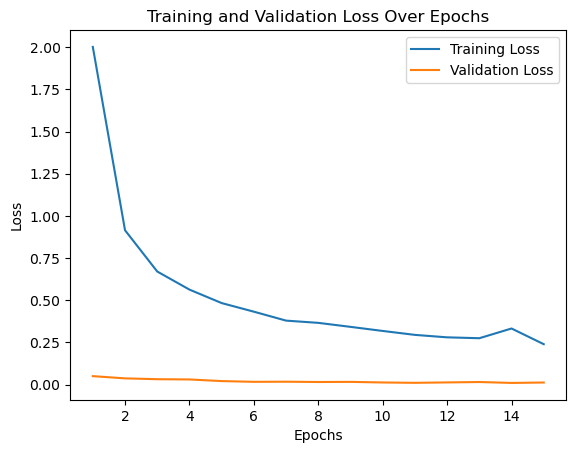


	Accuracy: 93.99%




NameError: name 'end_time' is not defined

In [14]:
import time
from tqdm import tqdm

# Training loop
start_time = time.time()
n_total_steps = len(train_data_loader)
train_epoch_losses = []
val_losses = []

print(f'\n {"="*30}')

with tqdm(total=n_epochs, desc='Epochs') as pbar_epoch:
    for epoch in range(n_epochs):
        epoch_train_loss = 0.0
        
        with tqdm(total=len(train_data_loader), desc=f'Epoch {epoch+1}', leave=False) as pbar_batch:
            for i, (images, labels) in enumerate(train_data_loader):
                images = images.to(device)
                labels = labels.to(device)

                # forward
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item()
                
                pbar_batch.set_postfix(loss=loss.item())
                pbar_batch.update(1)
        
        epoch_train_loss /= len(train_data_loader)
        train_epoch_losses.append(epoch_train_loss)
        
        with torch.no_grad():
            model.eval()
            val_loss = 0.0
            for images, labels in val_data_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
            val_loss /= len(val_data_loader.dataset)
            val_losses.append(val_loss)
        
        pbar_epoch.update(1)
        pbar_batch.refresh()  # To show the latest loss in the progress bar

print(f'{"="*30}\n')
end_time = time.time() - start_time

#===========================================================================
#test the trained model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in val_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    accuracy = n_correct * 100.0 / n_samples
    print(f'\tAccuracy: {accuracy:.2f}%')
    
print(f'\n {"="*30}\n')
print(f'  Training Time: {end_time/60:.2f} Minute(s)')
print(f'\n {"="*30}\n')


In [15]:
save_path = r'./plantvillage.pth3'
# device = torch.device('cpu')
torch.save(model.state_dict(), save_path)
print('successfully saved')

successfully saved


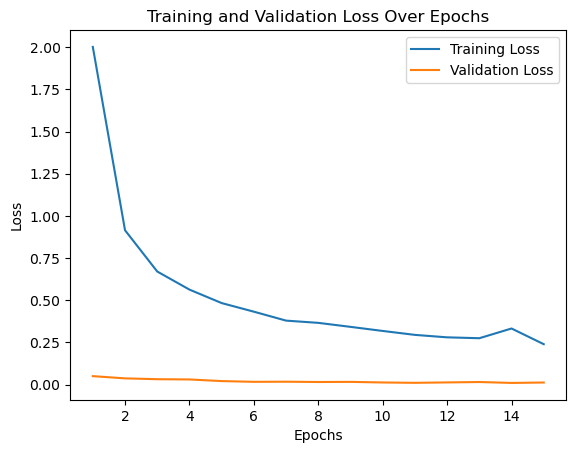

In [18]:
# 绘制损失曲线
plt.plot(range(1, n_epochs + 1), train_epoch_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
# 保存图像
plt.savefig('loss_curve.png')

plt.show()
